In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_colwidth', 400)

# DATA CLEANING
# ======================

# FISH DETAILS Table
# ======================

In [2]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_FROZEN.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_STD.x': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY.x': 'object',  # two entries that at 3?, (also 1 that is 44), convert to numeric, coerce errors
    'GONAD_WEIGHT': 'object',  # some '.' / 'NA', convert to numeric, coerce error to make 'NA' actually null
    'Ager.1': 'object',
    'AGE.1': 'object',  # convert to numeric and separate text comments
    'FSP.1': 'object',  # convert to numeric and separate text comments
    'Comments.1': 'object', 
    'Ager.2': 'object',  
    'AGE.2': 'object',  # convert to numeric and separate text comments
    'FSP.2': 'object',  # convert to numeric and separate text comments
    'Comments.2': 'object', 
    'Ager.3': 'object', 
    'AGE.3': 'object',  # convert to numeric and separate text comments
    'FSP.3': 'object',  # convert to numeric and separate text comments
    'Comments.3': 'object', 
    'Envelop Comments': 'object'
} 

df_FD = pd.read_excel('provided data\\Gaspereau Ages_Combined.xlsx', dtype=dtypes)

# create a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes_1'] = df_FD['AGE.1']
df_FD['FSP_notes_1'] = df_FD['FSP.1']
df_FD['AGE_notes_2'] = df_FD['AGE.2']
df_FD['FSP_notes_2'] = df_FD['FSP.2']
df_FD['AGE_notes_3'] = df_FD['AGE.3']
df_FD['FSP_notes_3'] = df_FD['FSP.3']

# convert to numeric and coerce errors
df_FD['FL_WET.x'] = np.round(pd.to_numeric(df_FD['FL_WET.x'], errors='coerce')).astype('Int32')
df_FD['FL_FROZEN.x'] = pd.to_numeric(df_FD['FL_FROZEN.x'], errors='coerce').astype('Int32')
df_FD['MATURITY.x'] = pd.to_numeric(df_FD['MATURITY.x'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')
df_FD['AGE.2'] = pd.to_numeric(df_FD['AGE.2'], errors='coerce').astype('Int32')
df_FD['FSP.2'] = pd.to_numeric(df_FD['FSP.2'], errors='coerce').astype('Int32')
df_FD['AGE.3'] = pd.to_numeric(df_FD['AGE.3'], errors='coerce').astype('Int32')
df_FD['FSP.3'] = pd.to_numeric(df_FD['FSP.3'], errors='coerce').astype('Int32')

# rename keys with '.' for ease of use within pandas
rename_FD = {
    'FL_WET.x': 'FL_WET', 
    'FL_FROZEN.x': 'FL_FROZEN',
    'FL_STD.x': 'FL_STD', 
    'MATURITY.x': 'MATURITY',
    'Ager.1': 'Ager_1',
    'AGE.1': 'AGE_1',
    'FSP.1': 'FSP_1',
    'Comments.1': 'Comments_1',
    'Ager.2': 'Ager_2',
    'AGE.2': 'AGE_2',
    'FSP.2': 'FSP_2',
    'Comments.2': 'Comments_2',
    'Ager.3': 'Ager_3',
    'AGE.3': 'AGE_3',
    'FSP.3': 'FSP_3',
    'Comments.3': 'Comments_3'
}
df_FD = df_FD.drop('Unnamed: 0', axis=1).rename(columns=rename_FD)

### SITE: Backup, Split, Remap 1st Entry
* convert to int for processing (will be undone during import)

In [3]:
# how many named vs na sites
(
    sum(~df_FD.SITE.astype(str).str.isnumeric()) - sum(df_FD.SITE.isin(['1A', '1B'])) - df_FD[df_FD.SITE.isnull()].shape[0], 
    df_FD[df_FD.SITE.isnull()].shape[0], 
    sum(~df_FD.SITE.astype(str).str.isnumeric()) - sum(df_FD.SITE.isin(['1A', '1B']))
)
# named, null, total ambiguous

(1804, 118, 1922)

In [4]:
# add a flag for sites if there is ambiguous data (ie, names, multiple sites, alternate nomenclature)
df_FD.loc[(
    df_FD.SITE.isnull() | ~(df_FD.SITE.astype(str).str.isnumeric() | df_FD.SITE.isin(['1A', '1B']))
), 'FLAG_SITE'] = True

# how many Site flags are there?
df_FD[df_FD.FLAG_SITE == True].shape[0]

1922

In [5]:
# clean the site column before investigating in detail

# backup exact site entries as site notes
df_FD['SITE_notes'] = df_FD['SITE'].astype('str')

# Expand and Clean Site Column
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE.astype('str').str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

In [6]:
# remap sites to numeric, overwrite SITE (after backing up notes), convert to integer

# these indices/numbers are important/exact, but will be undone on import to dm_apps
# these are consistent with older analysis, other tables, and import script into dm_apps
remap_sites = {
    '1A': 90,
    '1B': 91,
    '47or62': 47,
    'EricMcFarlane': 92,
    'E.MACFARLANE': 92,
    'EricMacFarlane': 92,
    'EricMac': 92,
    'JimmyMacFarlane': 93,
    'JMcFarlane': 93,
    'JohnAlbertCoady': 94,
    'JACoady': 94,
    '11K3(435': 95
}

df_FD['SITE1'] = df_FD.replace({'SITE1': remap_sites}).SITE1
df_FD['SITE1'] = pd.to_numeric(df_FD['SITE1'], errors='coerce').astype('Int32')

## Naming Issues

In [7]:
# extra space
df_FD.loc[df_FD.PERIOD == 'PM ', 'PERIOD'] = 'PM'

# formatting
df_FD.loc[df_FD.CONDITION == 'FROZEN', 'CONDITION'] = 'Frozen'
df_FD.loc[df_FD.CONDITION == 'FRESH', 'CONDITION'] = 'Fresh'

### PERIOD: 'AD' vs 'AM' - FLAGGED
* (118 entries)
* Other CSV also include AD periods for entered data

In [8]:
# Set a flag for AD period data
df_FD.loc[df_FD.PERIOD == 'AD', 'FLAG_AM_PM_PERIOD'] = True

# how many flagged data?
df_FD[df_FD.FLAG_AM_PM_PERIOD == True].shape[0]

118

### SEX: leave or null 'B' / 'A?' - FLAGGED
* maybe B is 'both' (if so, could change label to 'H' for hermaphrodite)

In [9]:
sum(df_FD.SEX == 'B'), sum(df_FD.SEX == 'A?')

(1, 1)

In [10]:
# flag sex typos
df_FD.loc[(df_FD.SEX == 'B') | (df_FD.SEX == 'A?'), 'FLAG_SEX'] = True

# how many flags
df_FD[df_FD.FLAG_SEX == True].shape[0]

2

## Outliers

### MATURITY: 0 - FLAGGED
* NOTE: could also set this to 9 (unknown), or 99 (Abnormal)

### MATURITY: 44 - FLAGGED
* could also be typo for 4
* NOTE: could also set this to 9 (unknown), or 99 (Abnormal)

In [11]:
sum(df_FD[df_FD.MATURITY.notna()].MATURITY == 0), sum(df_FD[df_FD.MATURITY.notna()].MATURITY == 44)

(2, 1)

In [12]:
# Flag Maturity Outliers / Typos

df_FD.loc[(df_FD.MATURITY == 0) | (df_FD.MATURITY == 44), 'FLAG_MATURITY'] = True

# how many flags?
df_FD[df_FD.FLAG_MATURITY == True].shape[0]

3

### FSP_1: 33 - FLAGGED
* could also be typo for 3

In [13]:
sum(df_FD[df_FD.FSP_1.notna()].FSP_1 == 33)

1

In [14]:
# Flag FSP outliers

df_FD.loc[(df_FD.FSP_1 == 33), 'FLAG_FSP_1'] = True

# how many flags?
df_FD[df_FD.FLAG_FSP_1 == True].shape[0]

1

### Q: What is happening with the ~2019 data?

##### data input issues?
* there were order of magnitude difference betwwen FL_STD:
  * look to be 10x smaller
* similarly, month 6, there were five strange entries for FL_WET and FL_FROZEN


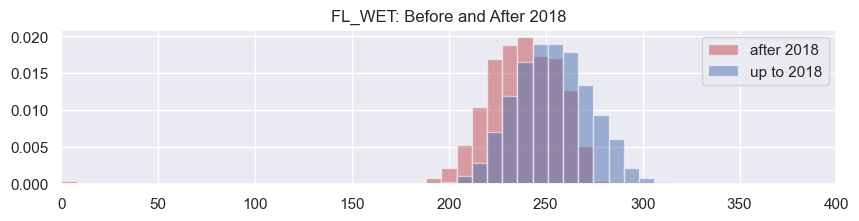

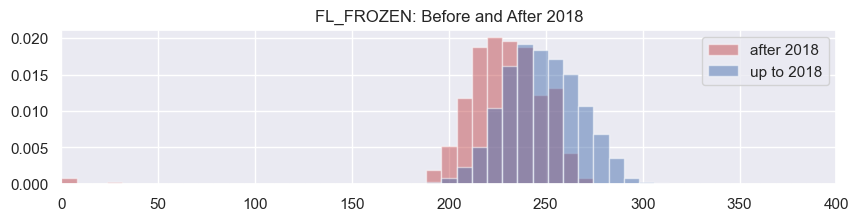

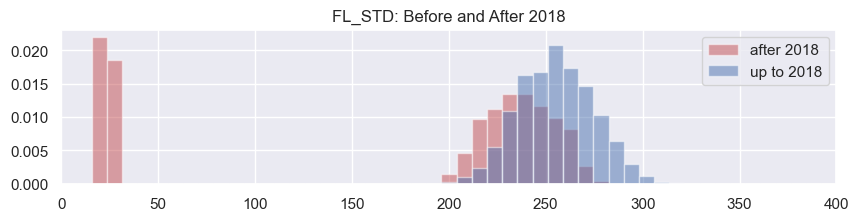

In [15]:
def hist_compare_years(year, feature, bins=50, xmin=0, xmax=400):
    
    plt.figure(figsize=(10,2))
    plt.xlim(xmin, xmax)
    
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    
    df_FD.loc[df_FD.DATETIME.dt.year > year, feature].hist(alpha=0.5, color=sns.color_palette()[3], density=True, label=f'after {year}', bins=bins_plot)
    df_FD.loc[df_FD.DATETIME.dt.year <= year, feature].hist(alpha=0.5, density=True, label=f'up to {year}', bins=bins_plot)
    
    plt.legend(loc='upper right')
    
    plt.title(feature.upper() + ': Before and After ' + str(year))
    plt.show()
    

# compare years and features
features_to_compare = ['FL_WET', 'FL_FROZEN', 'FL_STD']
years_to_compare = [2018]

for feature in features_to_compare:
    for year in years_to_compare:
        hist_compare_years(year, feature)

### FL_STD: outliers - FLAGGED

In [16]:
# how many length outliers?

sum(df_FD.FL_STD < 100)

264


outlier min date: 2019-05-31 00:00:00
outlier max date: 2019-06-21 00:00:00


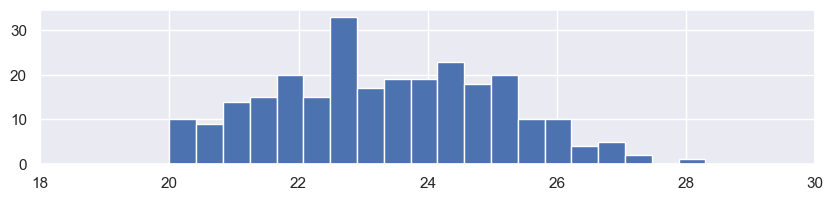

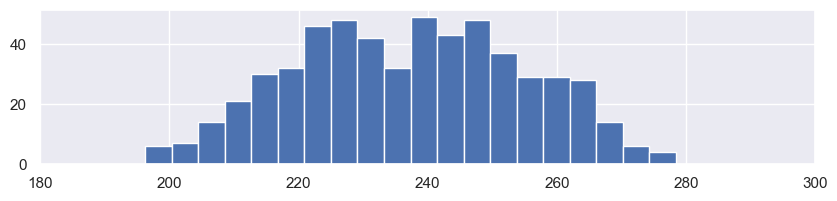

In [17]:
# looks like it's off by a multiple
print()
print('outlier min date:', df_FD[df_FD.FL_STD < 100].DATETIME.min())
print('outlier max date:', df_FD[df_FD.FL_STD < 100].DATETIME.max())

df_FD[df_FD.FL_STD < 100].FL_STD.hist(figsize=(10,2), bins=20)
plt.xlim(18, 30)
plt.show()

# histogram of same year, excluding outliers
df_FD[(df_FD.YEAR == 2019) & (df_FD.FL_STD > 100)].FL_STD.hist(figsize=(10,2), bins=20)
plt.xlim(180, 300)
plt.show()

In [18]:
# flag outlier FL_STD
df_FD.loc[(df_FD.FL_STD < 100), 'FLAG_FL_STD'] = True

# how many flags?
df_FD[df_FD.FLAG_FL_STD == True].shape[0]

264

### FL_WET and FL_FROZEN: outliers - FLAGGED

In [19]:
# these also look like they are off by multiples

print('median FL_WET: ', df_FD.FL_WET.median())
print('median FL_FROZEN: ', df_FD.FL_FROZEN.median())

display(df_FD[(df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)][['FL_WET', 'FL_FROZEN']])

median FL_WET:  251.0
median FL_FROZEN:  247.0


,FL_WET,FL_FROZEN
35048,2,3
35161,28,28
35241,2,2
35246,1,1
35247,2,3


In [20]:
# flag outlier FL_WET and FL_FROZEN
df_FD.loc[((df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)), 'FLAG_FL_WET_FROZEN'] = True

# how many flags?
df_FD[df_FD.FLAG_FL_WET_FROZEN == True].shape[0]

5

## STD from Frozen: impute std from wet or frozen (in dm_apps)
* update dm_apps to take in fresh or frozen lengths and output standardised lengths
* below is a summary of:
    * missing data that can be added
    * accuracy calculations for this conversion
    * notes regarding outliers/exceptions
* conclusion: this method will work in dm_apps, with no major discrepancies in non-flagged entries

In [21]:
# how many FL_WET or FROZEN but not FL_STD exist?

TEMP = df_FD[df_FD.FL_STD.isnull() & (df_FD.FL_WET.notna() | df_FD.FL_FROZEN.notna())][['DATETIME', 'FL_WET', 'FL_FROZEN', 'FL_STD']]
print(TEMP.shape[0], 'entries\n')

1457 entries



In [22]:
# what is the ratio, FROZEN to STD

TEMP = df_FD[df_FD.FL_STD.notna() & df_FD.FL_FROZEN.notna()]
(TEMP.FL_STD / TEMP.FL_FROZEN).describe()

count   25331.000
mean        1.034
std         0.148
min         0.896
25%         1.031
50%         1.032
75%         1.034
max        20.000
dtype: float64

In [23]:
# how many missing values
(
    sum(df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna()),                             # only frozen FL data
    sum(df_FD.FL_STD.isnull() & df_FD.FL_WET.notna()),                                # only wet FL data
    sum(df_FD.FL_STD.isnull() & (df_FD.FL_FROZEN.notna() | df_FD.FL_WET.notna()))     # either wet or frozen data, but not std FL data
)
# frozen, wet, both

(264, 1193, 1457)

### ANALYSE CONVERSION FACTOR FROZEN TO STD
* based on David's question

In [24]:
temp = df_FD[['FL_FROZEN', 'FL_STD']].dropna()
temp = pd.DataFrame(temp.FL_FROZEN * 1.033 / temp.FL_STD, columns=['factor'])
temp.describe(percentiles=[0.025, 0.975]).T

# 95% CI is very small, some extreme outliers (see below)

,count,mean,std,min,2.5%,50%,97.5%,max
factor,25331.000,1.000,0.012,0.052,0.996,1.001,1.004,1.152


In [25]:
# check outliers
frozen_outliers = temp[(temp.factor < 1-3*0.012) | (temp.factor > 1+3*0.012)]

# indices of outliers
frozen_outliers_idx = set(frozen_outliers.index)

# outliers in full dataframe
df_FD.iloc[df_FD.index.isin(frozen_outliers_idx)]

# These are already flagged!

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,DATETIME,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN
35048,2019,6,14,7,25,PM,Frozen,7,2,3,25.900,221.300,B,M,4,NaN,JM,6,3,"Ck Lgth, Possible 5-3",NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-14,6,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35161,2019,6,19,8,41,PM,Frozen,28,28,28,25.100,228.600,A,F,4,35.900,JM,5,4,?able4,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-19,5,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35241,2019,6,21,8,41,AM,Frozen,36,2,2,22.800,151.800,B,F,4,16.100,JM,4,4,Root+Apex,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35246,2019,6,21,8,41,AM,Frozen,7,1,1,20.000,97.000,B,M,4,NaN,JM,4,3,Ck Lgth,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35247,2019,6,21,8,41,AM,Frozen,8,2,3,20.400,103.800,B,M,4,NaN,JM,3,3,Dark,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,3,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True


In [26]:
# let's make sure wet data is always equals standardised

temp = df_FD[['FL_WET', 'FL_STD']].dropna()
temp = pd.DataFrame(temp.FL_WET / temp.FL_STD, columns=['factor'])
temp.describe(percentiles=[0.025, 0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
factor,9660.000,1.000,0.019,0.050,1.000,1.000,1.000,1.116


In [27]:
# check outliers
wet_outliers = temp[temp.factor != 1]

# indices of outliers
wet_outliers_idx = set(wet_outliers.index)

# outliers in full dataframe
df_FD.iloc[df_FD.index.isin(wet_outliers_idx)]

# These are already flagged (again)!!

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,DATETIME,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN
35048,2019,6,14,7,25,PM,Frozen,7,2,3,25.900,221.300,B,M,4,NaN,JM,6,3,"Ck Lgth, Possible 5-3",NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-14,6,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35161,2019,6,19,8,41,PM,Frozen,28,28,28,25.100,228.600,A,F,4,35.900,JM,5,4,?able4,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-19,5,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35241,2019,6,21,8,41,AM,Frozen,36,2,2,22.800,151.800,B,F,4,16.100,JM,4,4,Root+Apex,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35246,2019,6,21,8,41,AM,Frozen,7,1,1,20.000,97.000,B,M,4,NaN,JM,4,3,Ck Lgth,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True
35247,2019,6,21,8,41,AM,Frozen,8,2,3,20.400,103.800,B,M,4,NaN,JM,3,3,Dark,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-21,3,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,True


In [28]:
# check whether frozen lengths are ever equal to standardised lengths
df_FD[df_FD.FL_FROZEN == df_FD.FL_STD]
# No.

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,DATETIME,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN


### fish_length from FL_WET/FL_FROZEN/FL_STD
* take the measured length, standardise in dm_apps based on frozen or fresh condition

        @property
        def standardised_length(self):
            """
            STD length = (1.0143 * Fork Length Frozen) + 4.557
            Rounded to the nearest mm
            """
            if self.condition == 2:
                return round(self.fish_length * 1.0143 + 4.557)
            else:
                return round(self.fish_length)

In [29]:
# all errors with this should already be flagged, let's check
df_FD['fish_length'] = df_FD['FL_WET'].fillna(df_FD['FL_FROZEN'])

In [30]:
df_FD[df_FD.CONDITION == 'Fresh'].shape[0], df_FD[df_FD.CONDITION == 'Frozen'].shape[0]

(10835, 25882)

In [31]:
# Check 1 good: all fresh fish have correct FL_WET (or missing FL_STD, so we can't say either way)
df_FD[(df_FD.CONDITION == 'Fresh') & (df_FD.fish_length != df_FD.FL_STD) & (df_FD.FL_STD.notnull())][['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'fish_length']]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,fish_length


In [32]:
# Check 2 good: the only fish_length > standardised length is already flagged
df_FD[(df_FD.CONDITION == 'Frozen') & (df_FD.fish_length > df_FD.FL_STD)][['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'fish_length', 'FLAG_FL_WET_FROZEN']]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,fish_length,FLAG_FL_WET_FROZEN
35161,Frozen,28,28,25.100,28,True


In [33]:
# Check 3 good: 1 fish is correctly converted (see below), the rest are already flagged
df_FD[(df_FD.CONDITION == 'Frozen') & (df_FD.fish_length < df_FD.FL_STD * 0.95)][['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'fish_length', 'FLAG_FL_WET_FROZEN']]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,fish_length,FLAG_FL_WET_FROZEN
30066,Frozen,<NA>,112,118.000,112,NaN
35048,Frozen,2,3,25.900,2,True
35241,Frozen,2,2,22.800,2,True
35246,Frozen,1,1,20.000,1,True
35247,Frozen,2,3,20.400,2,True


In [34]:
# that first entry was flagged by my arbitrary 95%, but is just a small fish, the conversion was correct, and the check caught it correctly
temp_length = 112
temp_length / (4.557 + 1.0143 * temp_length), round(4.557 + 1.0143 * temp_length)

# the other issues are already flagged

(0.9478785293664618, 118)

In [35]:
# check 4: are any std available, but fish_length are missing?
# ALREADY FLAGGED: these are all flagged as fish that were recorded in cm, not mm
df_FD[(df_FD.fish_length.isna()) & (df_FD.FL_STD.notnull())][['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'fish_length', 'FLAG_FL_STD']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CONDITION,259,2,Frozen,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FL_WET,0,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
FL_FROZEN,0,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
FL_STD,259.000,NaN,NaN,NaN,23.378,1.695,20.200,22.000,23.300,24.700,28.300
fish_length,0,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
FLAG_FL_STD,259,1,True,259,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# this contains both fresh and frozen fish - when imputing values
df_FD[(df_FD.fish_length.isna()) & (df_FD.FL_STD.notnull())]['CONDITION'].value_counts()

Frozen    194
Fresh      65
Name: CONDITION, dtype: int64

# FLAGGED: should the frozen fish with the cm inputting error be assumed to be standardised or not standardised yet?
(they are in the FL_STD column, but they were recorded quickly and incorrectly)

### WEIGHT: outliers - FLAGGED
* they all look real except 1934g fish which could be checked manually

In [37]:
max_weight = 500

df_FD.loc[df_FD.WEIGHT > max_weight]

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,DATETIME,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN,fish_length
718,1984,5,1,<NA>,12,NaN,Frozen,30,<NA>,316,325.000,519.000,A,F,2,NaN,NaN,7,6,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1984-05-01,7,6,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,316
914,1984,5,2,<NA>,12,NaN,Frozen,1,<NA>,316,325.000,539.000,A,F,2,NaN,NaN,8,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1984-05-02,8,4,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,316
1348,1984,5,8,<NA>,12,NaN,Frozen,27,<NA>,310,319.000,501.000,A,F,2,NaN,NaN,8,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1984-05-08,8,3,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,310
1800,1985,5,16,<NA>,12,NaN,Frozen,5,<NA>,317,326.000,512.000,A,F,2,83.000,NaN,9,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1985-05-16,9,3,NaN,NaN,NaN,NaN,NaN,12,12,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,317
5324,1989,5,13,<NA>,35,PM,Frozen,23,<NA>,305,314.000,503.000,A,F,4,95.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1989-05-13,4,4,NaN,NaN,NaN,NaN,NaN,35,35,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,305
34988,2019,6,11,7,41,PM,Frozen,1,<NA>,<NA>,24.900,1934.000,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2019-06-11,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,True,NaN,<NA>


In [38]:
# flag weight outliers
df_FD.loc[(df_FD.WEIGHT > max_weight), 'FLAG_WEIGHT_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_WEIGHT_OUTLIER == True].shape[0]

6

### CONFIRMED: outliers get flagged in dm_apps 
* based on David's question from the meeting
    
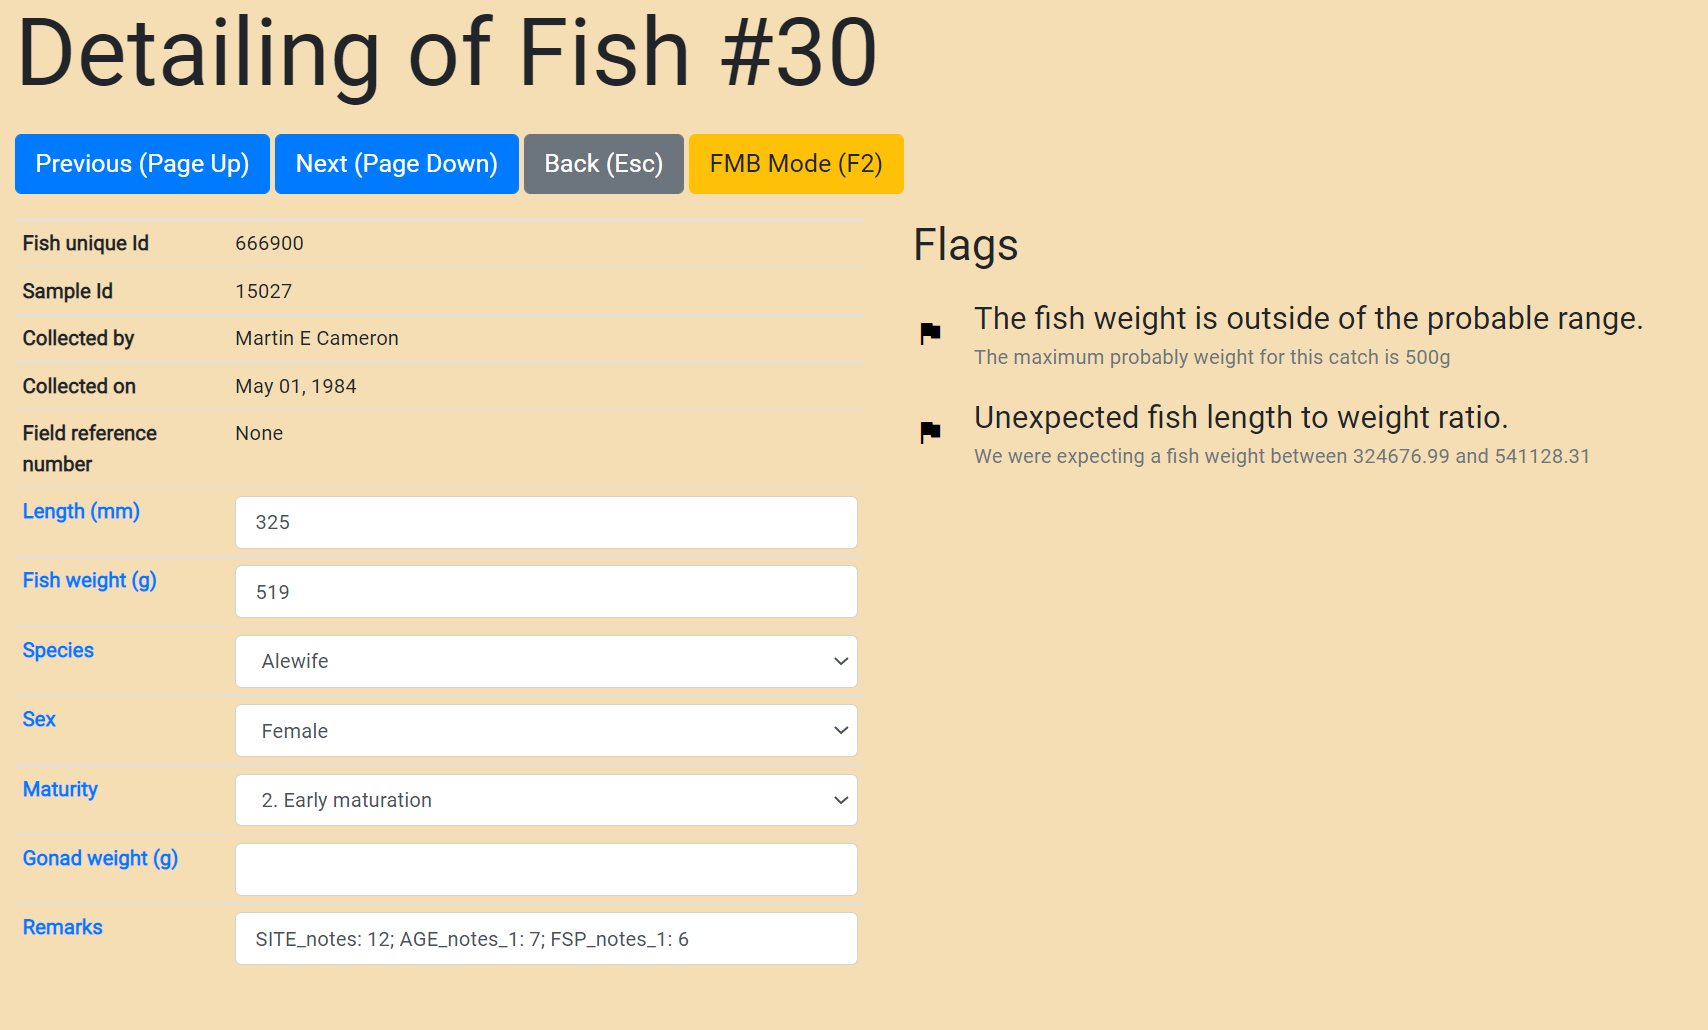

### GONAD_WEIGHT: outliers - FLAGGED

In [39]:
max_gonad_weight = 200

df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight]

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,Ager_1,AGE_1,FSP_1,Comments_1,Ager_2,AGE_2,FSP_2,Comments_2,Ager_3,AGE_3,FSP_3,Comments_3,Envelop.Comments,DATETIME,AGE_notes_1,FSP_notes_1,AGE_notes_2,FSP_notes_2,AGE_notes_3,FSP_notes_3,FLAG_SITE,SITE_notes,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,FLAG_SEX,FLAG_MATURITY,FLAG_FSP_1,FLAG_FL_STD,FLAG_FL_WET_FROZEN,fish_length,FLAG_WEIGHT_OUTLIER
5590,1989,5,16,<NA>,38,PM,Frozen,41,<NA>,270,278.000,283.000,A,F,4,417.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1989-05-16,4,4,NaN,NaN,NaN,NaN,NaN,38,38,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,270,NaN
14050,1995,6,2,5,"41,35",AM,Frozen,7,<NA>,276,284.000,337.000,A,F,4,766.000,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,1995-06-02,NaN,NaN,NaN,NaN,NaN,NaN,True,"41,35",41,35,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,276,NaN
23051,2008,5,20,4,26,AM,Frozen,14,<NA>,260,268.000,277.300,A,F,4,414.800,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2008-05-20,5,4,NaN,NaN,NaN,NaN,NaN,26,26,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,260,NaN
23498,2008,6,4,6,5,AM,Fresh,24,240,<NA>,240.000,176.400,A,F,4,219.600,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2008-06-04,3,3,NaN,NaN,NaN,NaN,NaN,5,5,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,240,NaN
25251,2010,5,5,2,41,PM,Frozen,30,<NA>,262,270.000,233.700,A,F,4,335.500,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2010-05-05,4,3,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,262,NaN
26652,2011,6,4,5,41,AM,Fresh,32,255,<NA>,255.000,220.300,A,F,4,280.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2011-06-04,4,4,NaN,NaN,NaN,NaN,NaN,41,41,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,255,NaN
32829,2017,6,14,7,25,AM,Frozen,14,<NA>,246,254.000,183.400,B,F,4,256.000,JM,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,2017-06-14,5,3,NaN,NaN,NaN,NaN,NaN,25,25,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,246,NaN


In [40]:
# flag weight outliers
df_FD.loc[(df_FD.GONAD_WEIGHT > max_gonad_weight), 'FLAG_GONAD_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_GONAD_OUTLIER == True].shape[0]

7

### Create a combined 'remarks' column

In [41]:
FD_comments = [
    'SITE_notes', 
    'Ager_1', 'Ager_2', 'Ager_3', 
    'Comments_1', 'Comments_2', 'Comments_3', 'Envelop.Comments', 
    'AGE_notes_1', 'FSP_notes_1', 'AGE_notes_2', 'FSP_notes_2', 'AGE_notes_3', 'FSP_notes_3'
]

# # this complicated double lambda is a combination of these 3 concepts
# # there is likely a cleaner way to do this, so I left my logic here for posterity
# df_FD[FD_comments].apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)
# df_FD[FD_comments].apply(lambda x: x.name, axis=0).astype(str)
# df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0)

df_FD['remarks'] = df_FD[FD_comments].apply(lambda x: (x.dropna().name + ': ' + x.dropna().astype(str)), axis=0).apply(lambda x: '; '.join(x.dropna().astype(str)), axis=1)

In [42]:
# check a sample of the remarks
df_FD.sample(10)[['DATETIME', 'remarks']]

,DATETIME,remarks
36178,2021-06-03,SITE_notes: 25; Ager_2: LF; AGE_notes_2: 4; FSP_notes_2: 4
7988,1990-05-17,SITE_notes: 48; AGE_notes_1: 5; FSP_notes_1: 4
25240,2010-05-05,SITE_notes: 41; AGE_notes_1: 3; FSP_notes_1: 3
36177,2021-06-03,SITE_notes: 25; Ager_2: LF; AGE_notes_2: 3; FSP_notes_2: 3
15703,1998-05-27,SITE_notes: 38; AGE_notes_1: 4; FSP_notes_1: 3
30000,2014-06-27,SITE_notes: 62; Ager_1: JM; AGE_notes_1: 4; FSP_notes_1: 3
5224,1989-05-12,SITE_notes: 49; AGE_notes_1: 4; FSP_notes_1: 3
2582,1986-04-30,SITE_notes: 12; AGE_notes_1: 4; FSP_notes_1: 4
35154,2019-06-19,"SITE_notes: 41; Ager_1: JM; Comments_1: Ck Lgth, ?1 more; AGE_notes_1: 5; FSP_notes_1: 3"
36173,2021-06-03,SITE_notes: 25; Ager_2: LF; AGE_notes_2: 4; FSP_notes_2: 4


### why did maturity distributions change in the 90s?
* should we do anything to clean this?

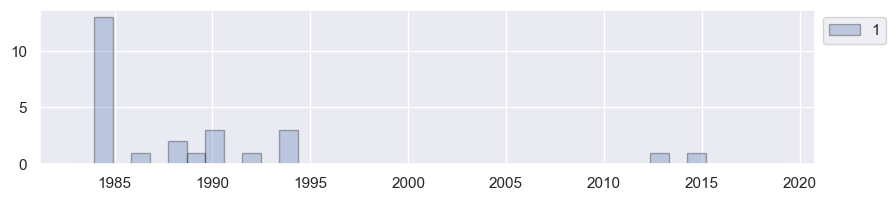

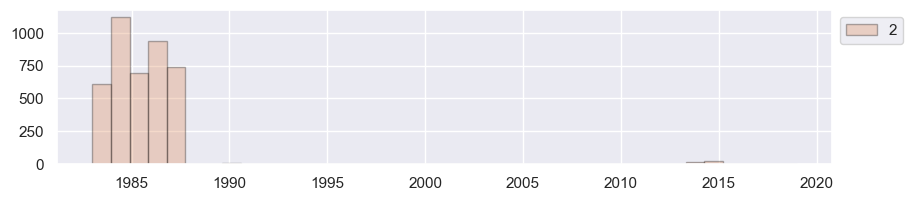

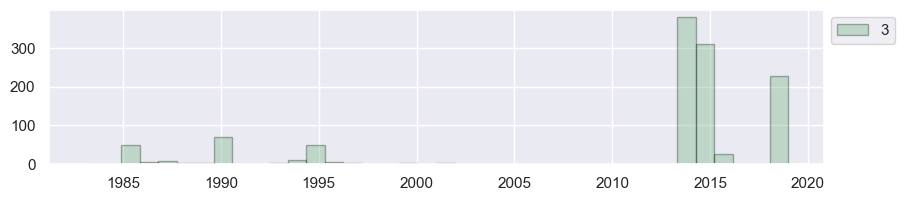

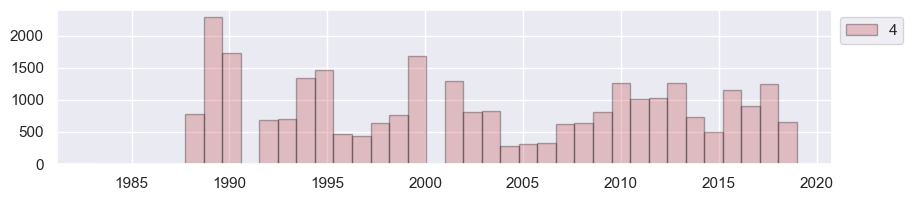

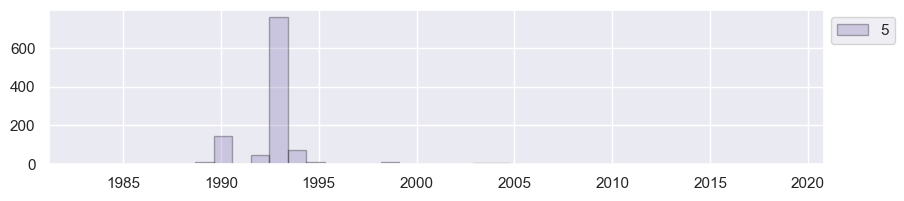

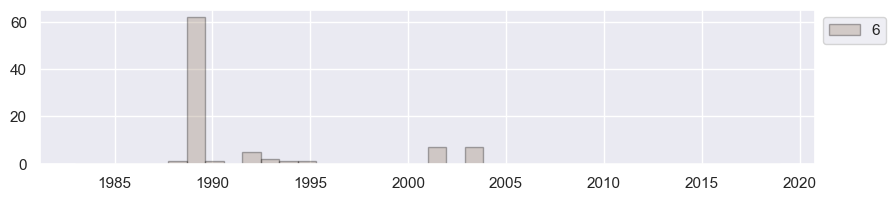

In [43]:
# graphs included in summary
# look into this, likely to just import as is

possible_maturity = [1, 2, 3, 4, 5, 6]

for i, maturity in enumerate(possible_maturity):

    plt.figure(figsize=(10, 2))
    xmin, xmax = 1983, 2019
    bins = 2019 - 1983 + 1
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 

    df_FD.loc[df_FD.MATURITY == maturity, 'DATETIME'].dt.year.hist(alpha=0.3, bins=bins_plot, label=maturity, edgecolor='black', color=sns.color_palette()[i])
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.show()

### Fish Details Sample ID (for import)
* Generate Unique IDs to Import / match with Samples

In [44]:
df_FD['id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE1.fillna(0).astype(int)
).astype('Int64')

#### some ambiguous sites can't get separated without more information

In [45]:
# unsorted bad sort (SHOULD BE UNSORTED, BUT NEED TO SORT AFTER WITHOUT CREATING AMBIGUITY)

bad_sort = set()
for i, row in df_FD[df_FD.id.isin(df_FD[df_FD.duplicated(['id', 'FISH_NO'], keep=False)].groupby('id').count().index)].iterrows():
    if (df_FD.loc[i, 'FISH_NO'] == df_FD.loc[i-1, 'FISH_NO']) and (df_FD.loc[i, 'id'] == df_FD.loc[i-1, 'id']):
        bad_sort.add(df_FD.loc[i, 'id'])
        
len(bad_sort)

7

In [46]:
# if these get sorted, how do they loop disambiguate
temp = df_FD[df_FD.id.isin(bad_sort)].sort_values(['DATETIME', 'FISH_NO'])[['DATETIME', 'id', 'FISH_NO']].reset_index(drop=True)

for i, row in temp.iterrows():
    temp.loc[i, 'id'] += 1_000_000_000
    if i > 0:
        if temp.loc[i, 'FISH_NO'] == temp.loc[i-1, 'FISH_NO']:
            temp.loc[i, 'id'] += 1_000_000_000
            
# temp.sort_values(['DATETIME', 'id', 'FISH_NO'])  # most look like typos, SEE EXCEL FILE

* only one of these looks like a legit extra set of data: 2998050105 / 3998050105
* leave it for now unless we can figure out which sample gets fish_no 21 to 31

In [47]:
# Create distinct id for ambiguous groups of fish details

if df_FD.id.max() < 2_100_000_000:  # only run this once
    
    # first, flag ambiguous data
    
    # ambiguous ids 
    ambiguous_id = df_FD[df_FD.duplicated(['id', 'FISH_NO'], keep=False)].groupby('id').count().index

    # flag ambiguous ids / sample matches (same site and date)
    df_FD.loc[df_FD.id.isin(ambiguous_id), 'FLAG_MULTIPLE_SAMPLE_POSSIBILITIES'] = True    
    
    # some ambiguous sites have duplicate fish_no (most look like typos, 1 is probalby 2 separate samples worth of fish details)
    bad_sort = set()
    for i, row in df_FD[df_FD.FLAG_MULTIPLE_SAMPLE_POSSIBILITIES == True].iterrows():
        if (df_FD.loc[i, 'FISH_NO'] == df_FD.loc[i-1, 'FISH_NO']) and (df_FD.loc[i, 'id'] == df_FD.loc[i-1, 'id']):
            bad_sort.add(df_FD.loc[i, 'id'])
    
    # flag misnumbered fish detail grouping (these have already been flagged)
    df_FD.loc[df_FD.id.isin(bad_sort), 'FLAG_MISNUMBERED_FISH_DETAILS'] = True
    
    # sort after checking misnumbered sets
    ## sort by date, site, fish
    df_FD = df_FD.sort_values(['DATETIME', 'SITE', 'FISH_NO']).reset_index(drop=True)
    
    # now, disambiguate
    
    # start by adding 1B to all ambiguous id
    df_FD.loc[df_FD.id.isin(ambiguous_id), 'id'] = df_FD.loc[df_FD.id.isin(ambiguous_id), 'id'] + 1_000_000_000
    
    if re_id_misnumberd_fish := False:
        """don't do this because even for 2998050105, we can't know which of the samples gets fish #s 21-31"""    
        
        # do not re-id all of FLAG_MISNUMBERED_FISH_DETAILS, only 2998050105
        # loop through bad sort and if two fish numbers in a row, add an extra 1_000_000_000
        # there are never more than 2 duplicate fish_no linked to a single sample, so this should work
        for i, row in df_FD[df_FD.id == 2998050105].iterrows():
            if df_FD.loc[i, 'FISH_NO'] == df_FD.loc[i-1, 'FISH_NO']:
                df_FD.loc[i, 'id'] = row.id + 1_000_000_000
    
    # resort by id
    df_FD = df_FD.sort_values(['DATETIME', 'id', 'FISH_NO']).reset_index(drop=True)
    
    # the loop through fish with ambiguous id until fish_no 1 comes up AND the id didn't change, add an extra billion
    # ignore misnumbered fish
    multiplier = 0
    for i, row in df_FD[(df_FD.FLAG_MULTIPLE_SAMPLE_POSSIBILITIES == True) & (df_FD.FLAG_MISNUMBERED_FISH_DETAILS != True)].iterrows():
        if df_FD.loc[i, 'FISH_NO'] < df_FD.loc[i-1, 'id']:
            if df_FD.loc[i, 'id'] == df_FD.loc[i-1, 'id']:
                multiplier += 1
            else:
                multiplier = 0

        df_FD.loc[i, 'id'] = row.id + 1_000_000_000*multiplier


In [48]:
# NOTE: FLAG_MULTIPLE_SAMPLE_POSSIBILITIES is poorly named, should be ambiguous fish detail grouping or similar
# left as is, because already being used to examine data

# how many flags?
df_FD[df_FD.FLAG_MULTIPLE_SAMPLE_POSSIBILITIES == True].shape[0], df_FD[df_FD.FLAG_MISNUMBERED_FISH_DETAILS == True].shape[0]

(1034, 235)

In [49]:
still_ambiguous = list(df_FD[df_FD.duplicated(['id', 'FISH_NO'], keep=False)].groupby('id').count().index)
still_ambiguous

[2993052737,
 2993052952,
 2993060933,
 2998050105,
 3010050541,
 3010052925,
 3010061141]

In [50]:
# all of those are from bad_sort (which is good)
[x for x in [x + 1000000000 for x in  bad_sort ] if x not in still_ambiguous]

[]

In [51]:
# there aren't more than 2 dupes if sorted by date and site

current = 1
maxdupes = 1

for i, row in df_FD[df_FD.FLAG_MISNUMBERED_FISH_DETAILS == True].iterrows():
    if df_FD.loc[i, 'FISH_NO'] == df_FD.loc[i-1, 'FISH_NO']:
        current += 1
    else:
        current = 1
    maxdupes = max(current, maxdupes)

maxdupes

2

In [52]:
# there are never duplicates outside of FLAG_MISNUMBERED_FISH_DETAILS

current = 1
maxdupes = 1

for i, row in df_FD[df_FD.FLAG_MISNUMBERED_FISH_DETAILS.isnull()].iterrows():
    if i > 0:
        if df_FD.loc[i, 'FISH_NO'] == df_FD.loc[i-1, 'FISH_NO']:
            if df_FD.loc[i, 'id'] == df_FD.loc[i-1, 'id']:
                current += 1
        else:
            current = 1
    maxdupes = max(current, maxdupes)

maxdupes

1

### Validate weight to length ratio: outliers - FLAGGED

##### need to flag these and manually deal with them individually 


[4:25 PM] Fishman, David
would be based on length in cm and weight in g

<img style="float: left;" src=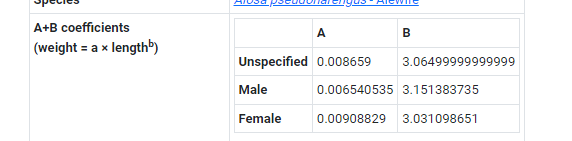>

In [53]:
# TODO: add a flag or boolean to identify outliers?


def lw_prediction_delta(sex, length_mm, weight_g):
    """
    returns actual weight / predicted weight, based on length and sex
    """
    
    sex, length_mm, weight_g = str(sex), float(length_mm), float(weight_g)
    
    if sex.lower()[0] == 'm':
        A, B = 0.00654, 3.15
    elif sex.lower()[0] == 'f':
        A, B = 0.00909, 3.03
    else:
        A, B = 0.00866, 3.06
        
    # in grams, length converted mm to cm
    predicted_weight_g = A * ((length_mm / 10) ** B)
    
    return weight_g / predicted_weight_g


In [54]:
# check the length width ratio outliers

# drop FLAG_LEN_WT_RATIO_OUTLIER before recalculating, ignore if doesn't exist
df_FD = df_FD.drop('FLAG_LEN_WT_RATIO_OUTLIER', axis=1, errors='ignore')

# initialise column to np.nan
df_FD['lw_ratio_check'] = np.nan  

# don't include any flagged data in averages
flagged_columns = [x for x in list(df_FD.columns) if 'FLAG' in str(x)]

for i, row in df_FD.iterrows():
    if row[flagged_columns].any():
        df_FD.loc[i, 'lw_ratio_check'] = np.nan
    else:
        try:
            df_FD.loc[i, 'lw_ratio_check'] = lw_prediction_delta(row['SEX'], row['FL_STD'], row['WEIGHT'])
        except TypeError:
            df_FD.loc[i, 'lw_ratio_check'] = np.nan
        
# number of samples with extraordinary dimensions
avg_ratio = df_FD['lw_ratio_check'].describe()['mean']
stdev = df_FD['lw_ratio_check'].describe()['std']

# how many standard deviations out should we examine?
n_stdev = 4
# with 3 stdev, there are 101 len wt ratio outliers excluding already flagged values

# min and max ratios
lw_ratio_min, lw_ratio_max = avg_ratio - n_stdev*stdev, avg_ratio + n_stdev*stdev

# flag lw ratio outliers
df_FD.loc[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max), 'FLAG_LEN_WT_RATIO_OUTLIER'] = True

# how many flags?
df_FD[df_FD.FLAG_LEN_WT_RATIO_OUTLIER == True].shape[0]

33

In [55]:
# here are our outliers
columns = ['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 'lw_ratio_check']
df_FD[df_FD.FLAG_LEN_WT_RATIO_OUTLIER == True][columns]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,lw_ratio_check
224,Fresh,257,<NA>,257.000,337.000,A,M,2,NaN,1.865
1228,Frozen,<NA>,248,256.000,335.000,A,M,2,NaN,1.877
1838,Frozen,<NA>,260,268.000,363.000,A,F,2,48.700,1.880
2370,Frozen,<NA>,225,233.000,250.000,A,F,3,10.100,1.978
3082,Frozen,<NA>,254,262.000,347.000,A,F,2,41.200,1.924
3756,Frozen,<NA>,226,234.000,282.000,A,U,2,NaN,2.103
4186,Fresh,258,<NA>,258.000,341.000,A,F,4,42.000,1.981
4328,Fresh,263,<NA>,263.000,346.000,A,F,4,71.200,1.897
4644,Fresh,233,<NA>,233.000,238.000,A,F,4,35.500,1.883
4750,Fresh,258,<NA>,258.000,332.000,A,F,4,66.500,1.929


##### check whether the coefficients look good
* they seem a bit wonkey
* the outliers are flagged based on the actual average so it shouldn't affect this sheet, 
* but dm_apps could potentially use more accurate coefficients for gaspereau

In [56]:
df_FD.lw_ratio_check.describe(percentiles=[0.01,0.05,0.95,0.99])

count   32140.000
mean        1.253
std         0.152
min         0.133
1%          0.970
5%          1.047
50%         1.242
95%         1.486
99%         1.602
max         8.741
Name: lw_ratio_check, dtype: float64

##### calculate the coefficients in mm for dm_apps

In [57]:
A, B = 0.00866, 3.06

lenthtemp = 250
wt_from_cm = A * ((lenthtemp / 10) ** B)
wt_from_mm = A * ((1/10) ** B) * (lenthtemp ** B)

# check if the math is good
wt_from_cm / wt_from_mm

0.9999999999999998

In [58]:
A_mm = A * ((1/10) ** B)
A_mm, f'{A_mm:.8f}'  # formatting

(7.542544689019659e-06, '0.00000754')

##### drop the lw_ratio_check before continuing

In [59]:
df_FD = df_FD.drop('lw_ratio_check', axis=1)

# ======================
# LENGTH FREQUENCIES Table

In [60]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

### Clean Date/Time and create DATETIME column

In [61]:
# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF['CleanTime'] = df_LF['Time']
df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] = df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] * 100
df_LF['CleanTime'] = pd.to_datetime(df_LF.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
df_LF.loc[df_LF['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF['DATETIME'] = pd.to_datetime(dict(
    year=df_LF['yy'], 
    month=df_LF['mm'], 
    day=df_LF['dd'], 
    hour=df_LF['CleanTime'].dt.hour, 
    minute=df_LF['CleanTime'].dt.minute
), errors='coerce')

df_LF = df_LF.drop('CleanTime', axis=1)

### Expand and Clean Site Column
* Later analysis shows matching with samples on the first noted site is more effective than combining multiple sites. 
* Consider adding extra sites to notes column or adding the ability to select multiple sites when inputting a sample.

In [62]:
df_LF[df_LF.site.isnull()].shape[0], df_LF[~(df_LF.site.str.isnumeric() | df_LF.site.isin(['1A', '1B']))].shape[0]
# null, total ambiguous

(69, 627)

In [63]:
# flag ambiguous sites
df_LF.loc[(
    df_LF.site.isnull() | ~(df_LF.site.str.isnumeric() | df_LF.site.isin(['1A', '1B']))
), 'FLAG_SITE'] = True

# how many flags?
df_LF[df_LF.FLAG_SITE == True].shape[0]

627

In [64]:
df_LF[['SITE1', 'SITE2', 'SITE3']] = df_LF.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

### Clean River Column

In [65]:
df_LF.loc[df_LF.river == 'SW Margaree', 'river'] = 'SW MARGAREE'
df_LF.river.unique()

array([nan, 'MARGAREE', 'SW MARGAREE'], dtype=object)

### Clean Location

In [66]:
# clean the typos
df_LF.loc[df_LF['loc'] == 'LOWER ', 'loc'] = 'LOWER'
df_LF.loc[df_LF['loc'] == 'LOWE', 'loc'] = 'LOWER'
df_LF['loc'].unique()

array(['LOWER', 'UPPER', nan], dtype=object)

### 'river' and 'loc' should be included in Sites
* See Sites Section of this workbook below

### Period: AD

In [67]:
df_LF.period.unique()

array(['PM', 'AM', 'AD'], dtype=object)

In [68]:
# counts: AM, PM, and AD
sum(df_LF.period == 'AM'), sum(df_LF.period == 'PM'), sum(df_LF.period == 'AD')

(6143, 5250, 47)

In [69]:
# flag AD periods
df_LF.loc[df_LF.period == 'AD', 'FLAG_AM_PM_PERIOD'] = True

# how many flags?
df_LF[df_LF.FLAG_AM_PM_PERIOD == True].shape[0]

47

### Length Frequency Sample ID (for import)
* Generate Unique IDs to Import / match with Samples

In [70]:
# replace non-numeric data with made up site numbers
# NOTE: These are converted back in import script
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
df_LF = df_LF.replace({'SITE1': id_replacements})

In [73]:
# 'unique' id column (ambiguities flagged)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [74]:
# loop through duplicated ids and look at these by inspection - make sure they all look doubled (except 2018061364)
# the only one that looks like a typo is 2018061364 (fixed next)

for duplicate_id in list(df_LF[~df_LF.new_id & df_LF.new_sample].id):
    idx = df_LF[df_LF.id == duplicate_id].index.values[0]
    
    before = 0
    after = df_LF[df_LF.id == duplicate_id].shape[0]-1
    
    print('\n', df_LF[df_LF.id == duplicate_id]['id'].values[0])
    display(df_LF.loc[idx-before:idx+after][['id', 'DATETIME', 'site', 'period', 'lgth', 'wt_lbs']])



 1998050105


,id,DATETIME,site,period,lgth,wt_lbs
3102,1998050105,1998-05-01,5,PM,235,10.000
3103,1998050105,1998-05-01,5,PM,240,10.000
3104,1998050105,1998-05-01,5,PM,245,10.000
3105,1998050105,1998-05-01,5,PM,250,10.000
3106,1998050105,1998-05-01,5,PM,255,10.000
3107,1998050105,1998-05-01,5,PM,260,10.000
3108,1998050105,1998-05-01,5,PM,265,10.000
3109,1998050105,1998-05-01,5,PM,270,10.000
3110,1998050105,1998-05-01,5,PM,275,10.000
3111,1998050105,1998-05-01,5,PM,280,10.000



 2000060726


,id,DATETIME,site,period,lgth,wt_lbs
4156,2000060726,2000-06-07,26,AM,215,158.000
4157,2000060726,2000-06-07,26,AM,220,158.000
4158,2000060726,2000-06-07,26,AM,225,158.000
4159,2000060726,2000-06-07,26,AM,230,158.000
4160,2000060726,2000-06-07,26,AM,235,158.000
4161,2000060726,2000-06-07,26,AM,240,158.000
4162,2000060726,2000-06-07,26,AM,245,158.000
4163,2000060726,2000-06-07,26,AM,250,158.000
4164,2000060726,2000-06-07,26,AM,255,158.000
4165,2000060726,2000-06-07,26,AM,260,158.000



 2000060926


,id,DATETIME,site,period,lgth,wt_lbs
4186,2000060926,2000-06-09,26,PM,215,141.000
4187,2000060926,2000-06-09,26,PM,220,141.000
4188,2000060926,2000-06-09,26,PM,225,141.000
4189,2000060926,2000-06-09,26,PM,230,141.000
4190,2000060926,2000-06-09,26,PM,235,141.000
4191,2000060926,2000-06-09,26,PM,240,141.000
4192,2000060926,2000-06-09,26,PM,245,141.000
4193,2000060926,2000-06-09,26,PM,250,141.000
4194,2000060926,2000-06-09,26,PM,255,141.000
4195,2000060926,2000-06-09,26,PM,260,141.000



 2000061538


,id,DATETIME,site,period,lgth,wt_lbs
4239,2000061538,2000-06-15,38,PM,205,139.000
4240,2000061538,2000-06-15,38,PM,210,139.000
4241,2000061538,2000-06-15,38,PM,215,139.000
4242,2000061538,2000-06-15,38,PM,220,139.000
4243,2000061538,2000-06-15,38,PM,225,139.000
4244,2000061538,2000-06-15,38,PM,230,139.000
4245,2000061538,2000-06-15,38,PM,235,139.000
4246,2000061538,2000-06-15,38,PM,240,139.000
4247,2000061538,2000-06-15,38,PM,245,139.000
4248,2000061538,2000-06-15,38,PM,250,139.000



 2001051605


,id,DATETIME,site,period,lgth,wt_lbs
4266,2001051605,2001-05-16,"5,26",AM,220,140.000
4267,2001051605,2001-05-16,"5,26",AM,225,140.000
4268,2001051605,2001-05-16,"5,26",AM,230,140.000
4269,2001051605,2001-05-16,"5,26",AM,235,140.000
4270,2001051605,2001-05-16,"5,26",AM,240,140.000
4271,2001051605,2001-05-16,"5,26",AM,245,140.000
4272,2001051605,2001-05-16,"5,26",AM,250,140.000
4273,2001051605,2001-05-16,"5,26",AM,255,140.000
4274,2001051605,2001-05-16,"5,26",AM,260,140.000
4275,2001051605,2001-05-16,"5,26",AM,265,140.000



 2003052326


,id,DATETIME,site,period,lgth,wt_lbs
5184,2003052326,2003-05-23,26,AM,230,30.000
5185,2003052326,2003-05-23,26,AM,235,30.000
5186,2003052326,2003-05-23,26,AM,240,30.000
5187,2003052326,2003-05-23,26,AM,245,30.000
5188,2003052326,2003-05-23,26,AM,250,30.000
5189,2003052326,2003-05-23,26,AM,255,30.000
5190,2003052326,2003-05-23,26,AM,260,30.000
5191,2003052326,2003-05-23,26,AM,265,30.000
5192,2003052326,2003-05-23,26,AM,270,30.000
5193,2003052326,2003-05-23,26,AM,275,30.000



 2009052026


,id,DATETIME,site,period,lgth,wt_lbs
6332,2009052026,2009-05-20 12:55:00,26,AM,220,139.000
6333,2009052026,2009-05-20 12:55:00,26,AM,225,139.000
6334,2009052026,2009-05-20 12:55:00,26,AM,230,139.000
6335,2009052026,2009-05-20 12:55:00,26,AM,235,139.000
6336,2009052026,2009-05-20 12:55:00,26,AM,240,139.000
6337,2009052026,2009-05-20 12:55:00,26,AM,245,139.000
6338,2009052026,2009-05-20 12:55:00,26,AM,250,139.000
6339,2009052026,2009-05-20 12:55:00,26,AM,255,139.000
6340,2009052026,2009-05-20 12:55:00,26,AM,260,139.000
6341,2009052026,2009-05-20 12:55:00,26,AM,265,139.000



 2009052226


,id,DATETIME,site,period,lgth,wt_lbs
6368,2009052226,2009-05-22 13:10:00,26,AM,225,128.000
6369,2009052226,2009-05-22 13:10:00,26,AM,230,128.000
6370,2009052226,2009-05-22 13:10:00,26,AM,235,128.000
6371,2009052226,2009-05-22 13:10:00,26,AM,240,128.000
6372,2009052226,2009-05-22 13:10:00,26,AM,245,128.000
6373,2009052226,2009-05-22 13:10:00,26,AM,250,128.000
6374,2009052226,2009-05-22 13:10:00,26,AM,255,128.000
6375,2009052226,2009-05-22 13:10:00,26,AM,260,128.000
6376,2009052226,2009-05-22 13:10:00,26,AM,265,128.000
6377,2009052226,2009-05-22 13:10:00,26,AM,270,128.000



 2010051126


,id,DATETIME,site,period,lgth,wt_lbs
6648,2010051126,2010-05-11 14:50:00,26,AM,230,43.000
6649,2010051126,2010-05-11 14:50:00,26,AM,235,43.000
6650,2010051126,2010-05-11 14:50:00,26,AM,240,43.000
6651,2010051126,2010-05-11 14:50:00,26,AM,245,43.000
6652,2010051126,2010-05-11 14:50:00,26,AM,250,43.000
6653,2010051126,2010-05-11 14:50:00,26,AM,255,43.000
6654,2010051126,2010-05-11 14:50:00,26,AM,260,43.000
6655,2010051126,2010-05-11 14:50:00,26,AM,265,43.000
6656,2010051126,2010-05-11 14:50:00,26,AM,270,43.000
6657,2010051126,2010-05-11 14:50:00,26,AM,275,43.000



 2010051926


,id,DATETIME,site,period,lgth,wt_lbs
6719,2010051926,2010-05-19 13:45:00,26,AM,225,129.000
6720,2010051926,2010-05-19 13:45:00,26,AM,230,129.000
6721,2010051926,2010-05-19 13:45:00,26,AM,235,129.000
6722,2010051926,2010-05-19 13:45:00,26,AM,240,129.000
6723,2010051926,2010-05-19 13:45:00,26,AM,245,129.000
6724,2010051926,2010-05-19 13:45:00,26,AM,250,129.000
6725,2010051926,2010-05-19 13:45:00,26,AM,255,129.000
6726,2010051926,2010-05-19 13:45:00,26,AM,260,129.000
6727,2010051926,2010-05-19 13:45:00,26,AM,265,129.000
6728,2010051926,2010-05-19 13:45:00,26,AM,270,129.000



 2010052726


,id,DATETIME,site,period,lgth,wt_lbs
6846,2010052726,2010-05-27 08:40:00,26,AM,225,117.000
6847,2010052726,2010-05-27 08:40:00,26,AM,230,117.000
6848,2010052726,2010-05-27 08:40:00,26,AM,235,117.000
6849,2010052726,2010-05-27 08:40:00,26,AM,240,117.000
6850,2010052726,2010-05-27 08:40:00,26,AM,245,117.000
6851,2010052726,2010-05-27 08:40:00,26,AM,250,117.000
6852,2010052726,2010-05-27 08:40:00,26,AM,255,117.000
6853,2010052726,2010-05-27 08:40:00,26,AM,260,117.000
6854,2010052726,2010-05-27 08:40:00,26,AM,265,117.000
6855,2010052726,2010-05-27 08:40:00,26,AM,270,117.000



 2018061364


,id,DATETIME,site,period,lgth,wt_lbs
10841,2018061364,2018-06-13,64,PM,215,92.000
10842,2018061364,2018-06-13,64,PM,220,92.000
10843,2018061364,2018-06-13,64,PM,225,92.000
10844,2018061364,2018-06-13,64,PM,230,92.000
10845,2018061364,2018-06-13,64,PM,235,92.000
10846,2018061364,2018-06-13,64,PM,240,92.000
10847,2018061364,2018-06-13,64,PM,245,92.000
10848,2018061364,2018-06-13,64,PM,250,92.000
10849,2018061364,2018-06-13,64,PM,255,92.000
10850,2018061364,2018-06-13,64,PM,260,92.000


# CONFIRM: fix typo at 10851

In [75]:
df_LF[(df_LF.DATETIME == '20180613') & (df_LF.site == '64')]
# it looks like row 10851 whould be length of 265 not 235

,yy,mm,dd,Time,river,week,site,loc,period,wt_lbs,wt_kg,lgth,freq,Flbin,DATETIME,FLAG_SITE,SITE1,SITE2,SITE3,FLAG_AM_PM_PERIOD,id,new_sample,new_id
10841,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,215,1,215,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,True,True
10842,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,220,7,220,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10843,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,225,28,225,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10844,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,230,39,230,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10845,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,235,65,235,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10846,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,240,51,240,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10847,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,245,26,245,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10848,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,250,25,250,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10849,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,255,13,255,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False
10850,2018,6,13,NaN,MARGAREE,7,64,UPPER,PM,92.000,41.700,260,1,260,2018-06-13,NaN,64,<NA>,<NA>,NaN,2018061364,False,False


In [76]:
# CONFIRM
if fix_10851_typo := True:
    df_LF.loc[10851, ['lgth', 'Flbin', 'length_bin_id']] = [265, 265, 26.5]

In [77]:
# Create distinct id for ambiguous groups of length frequencies

if df_LF.id.max() < 2_100_000_000: # only run this once
    
    # check for ambiguous ids
    duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)
    
    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to new length distributions with the same id
    previous_lgth, multiplier = 0, 0
    for i, row in df_LF[df_LF.id > 2_100_000_000].iterrows():

        current_lgth = row['lgth']
        
        if current_lgth < previous_lgth:
            if df_LF.loc[i, 'id'] == df_LF.loc[i-1, 'id']:
                multiplier += 1
            else:
                multiplier = 0

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth


In [78]:
df_LF = df_LF.drop(['new_id', 'new_sample'], axis=1)

### Length Bins

In [79]:
# use the same bins as used in the herring database (cm, grouped by 0.5s)
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

# CHECK IF THERE COULD BE SORTING ISSUES WITH LF

In [80]:
# it looks like 4018061364 is our only potential error (fixed earlier, now 2018061364)
df_LF.groupby('id').count().sort_values('yy')['yy'].head()

id
2007060235    1
1991051212    3
1994050848    4
2005050501    6
1991051312    6
Name: yy, dtype: int64

In [81]:
# loop through small counts above and look at them
# these look fine, unless there were multiple combined typos
smallgroups = list(df_LF.groupby('id').count().sort_values('yy')['yy'].head().index)

for group in smallgroups:
    idx = df_LF[df_LF.id == group].index.values[0]
    before = 2
    after = 8
    
    print('\n', df_LF[df_LF.id == group]['id'].values[0])
    display(df_LF.loc[idx-before:idx+after][['DATETIME', 'site', 'period', 'lgth', 'wt_lbs']])



 2007060235


,DATETIME,site,period,lgth,wt_lbs
5960,2007-06-01,47,PM,285,133.000
5961,2007-06-01,47,PM,295,133.000
5962,2007-06-02,35,PM,225,122.000
5963,2007-06-02,2,PM,230,122.000
5964,2007-06-02,2,PM,235,122.000
5965,2007-06-02,2,PM,240,122.000
5966,2007-06-02,2,PM,245,122.000
5967,2007-06-02,2,PM,250,122.000
5968,2007-06-02,2,PM,255,122.000
5969,2007-06-02,2,PM,260,122.000



 1991051212


,DATETIME,site,period,lgth,wt_lbs
946,1990-06-08 00:00:00,64,AM,285,NaN
947,1990-06-08 00:00:00,64,AM,293,NaN
948,1991-05-12 03:00:00,12,AM,265,1.000
949,1991-05-12 03:00:00,12,AM,270,1.000
950,1991-05-12 03:00:00,12,AM,275,1.000
951,1991-05-13 03:00:00,12,AM,265,11.000
952,1991-05-13 03:00:00,12,AM,270,11.000
953,1991-05-13 03:00:00,12,AM,275,11.000
954,1991-05-13 03:00:00,12,AM,280,11.000
955,1991-05-13 03:00:00,12,AM,285,11.000



 1994050848


,DATETIME,site,period,lgth,wt_lbs
10341,1994-06-01,41,AM,280,137.000
10342,1994-06-01,41,AM,300,137.000
10343,1994-05-08,48,AM,250,3.000
10344,1994-05-08,48,AM,255,3.000
10345,1994-05-08,48,AM,260,3.000
10346,1994-05-08,48,AM,265,3.000
10347,1994-06-02,49,PM,235,118.000
10348,1994-06-02,49,PM,240,118.000
10349,1994-06-02,49,PM,245,118.000
10350,1994-06-02,49,PM,250,118.000



 2005050501


,DATETIME,site,period,lgth,wt_lbs
5570,2004-06-16,5,PM,260,41.000
5571,2004-06-16,5,PM,265,41.000
5572,2005-05-05,1,PM,240,9.000
5573,2005-05-05,1,PM,250,9.000
5574,2005-05-05,1,PM,255,9.000
5575,2005-05-05,1,PM,260,9.000
5576,2005-05-05,1,PM,265,9.000
5577,2005-05-05,1,PM,270,9.000
5578,2005-05-07,26,PM,240,12.000
5579,2005-05-07,26,PM,245,12.000



 1991051312


,DATETIME,site,period,lgth,wt_lbs
949,1991-05-12 03:00:00,12,AM,270,1.000
950,1991-05-12 03:00:00,12,AM,275,1.000
951,1991-05-13 03:00:00,12,AM,265,11.000
952,1991-05-13 03:00:00,12,AM,270,11.000
953,1991-05-13 03:00:00,12,AM,275,11.000
954,1991-05-13 03:00:00,12,AM,280,11.000
955,1991-05-13 03:00:00,12,AM,285,11.000
956,1991-05-13 03:00:00,12,AM,290,11.000
957,1991-05-16 03:00:00,12,PM,255,11.000
958,1991-05-16 03:00:00,12,PM,260,11.000


# ======================
# SAMPLES Table
### (logbook)

In [83]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df_SD = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

### DATETIME - leave incomplete dates null - FLAGGED
* leave null when missing days/months?

In [84]:
df_SD['DATETIME'] = pd.to_datetime(
    df_SD['YEAR'].astype(str) + '-' + df_SD['MM'].astype(str) + '-' + df_SD['DD'].astype(str), 
    errors='coerce'  # coerce missing days and months into errors
)

sum(df_SD.DATETIME.isnull())

31

In [85]:
# add a flag for sites if there is a null datetime
df_SD.loc[df_SD.DATETIME.isnull(), 'FLAG_DATETIME'] = True

# how many Site flags are there?
df_SD[df_SD.FLAG_DATETIME == True].shape[0]

31

### replace hours_fished = 'maximum' with a number of hours - FLAGGED

In [86]:
df_SD.hours_fished.unique()

array(['14', '15', '10', '9', '12', '2', '0', '11', '8', '13', '7', '5',
       '4', '6', '3', '1', '16', '18', '17', nan, '7.5', '14.5', '15.5',
       '6.5', '5.5', '2.5', '9.5', '13.5', '0.5', '10.5', '11.5', '3.5',
       '12.5', '1.5', '4.5', '1.8', '16.5', 'maximum ', '8.5'],
      dtype=object)

In [87]:
sum(df_SD.hours_fished=='maximum ')

28

In [88]:
# flag 'maximum '
df_SD.loc[df_SD.hours_fished=='maximum ', 'FLAG_HOURS_FISHED'] = True

# how many flags?
df_SD[df_SD.FLAG_HOURS_FISHED == True].shape[0]

28

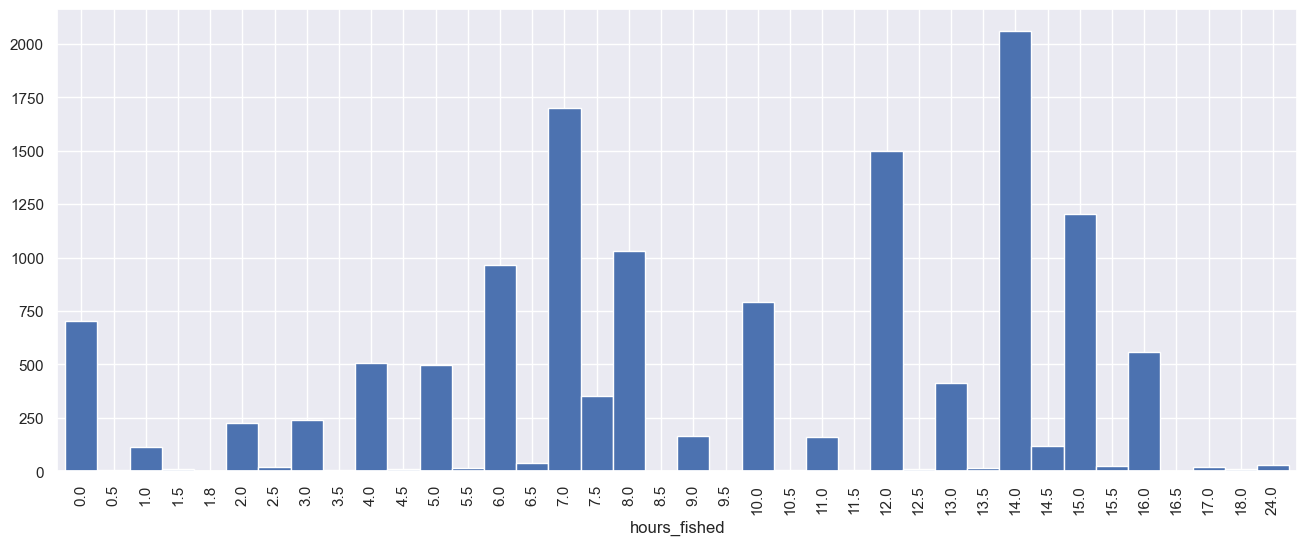

In [89]:
(
    df_SD.groupby('hours_fished')
    .count()
    .reset_index()
    .replace({'maximum ': 24})[['hours_fished', 'DIST']]
    .astype(float)
    .sort_values('hours_fished')
    .plot(kind='bar', x='hours_fished', y='DIST', width=1, figsize=(16, 6), legend=False)
);

### Samples.SITE_NO

In [90]:
[x for x in list(df_SD.SITE_NO.unique()) if not str(x).isnumeric()]

['1A', '1B', '1A,8']

In [91]:
sum(df_SD.SITE_NO=='1A,8'), sum(df_SD.SITE_NO=='1A'), sum(df_SD.SITE_NO=='1B'), sum(df_SD.SITE_NO=='1A,8') + sum(df_SD.SITE_NO=='1A') + sum(df_SD.SITE_NO=='1B')

(23, 62, 92, 177)

In [92]:
# add a flag for sites if there is ambiguous data (ie, names, multiple sites, alternate nomenclature)
df_SD.loc[(~df_SD.SITE_NO.str.isnumeric()) & (~df_SD.SITE_NO.isin(['1A', '1B'])), 'FLAG_SITE'] = True

# how many Site flags are there?
df_SD[df_SD.FLAG_SITE == True].shape[0]

23

In [93]:
# create columns for multiple sites
df_SD[['SITE1', 'SITE2']] = df_SD.SITE_NO.str.split(',', expand=True).fillna(pd.NA)

### clean bycatch / pre-generate 'remarks' before import

In [94]:
df_SD.bycatch_sbass.unique()

array([nan,  3.,  1.,  2.])

In [95]:
df_SD.bycatch_shad.unique()

array([nan,  1.])

In [96]:
df_SD.bycatch_other.unique()

array([nan, 'salmon', '1 perch, 1 speckled trou, 1 30 inch salmon',
       '1 lamprey eel (?)', '1', '2 trout', '1 trout', '5 lampreys',
       '1 baby lamprey', '4 trout, 3 "lamprey eels" (?)', '1 perch',
       '4 suckers', 'lamprey', '1 sucker'], dtype=object)

In [97]:
df_SD.comments.unique()

array([nan, 'striped bass were 23 inches',
       'river still high, fishing inside wing',
       'catch a salmon no marking 14 inch long', 'salted 4800 lbs',
       'salted 5000 lbs', 'outside wing in, river high',
       'salted 8000 lbs', '5 gaspereau', '26 gaspereau', 'did not fish',
       'Rainbow trout released', 'salmon', 'trout', 'salt', 'bait',
       'did not fish, returned logbook', 'wet snow', '6 fish',
       'heavy rain, flood', '3 fish', '10 fish', '1 fish', '8 fish',
       'heavy rain', 'did not fish on the 22nd. Water too high.'],
      dtype=object)

In [98]:
check_for_comments = ['comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other']

# update bycatch fields to text fields
df_SD.loc[df_SD['bycatch_sbass'].notna(), 'comment_sbass'] = 'bycatch_sbass: ' + df_SD[df_SD['bycatch_sbass'].notna()]['bycatch_sbass'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_shad'].notna(), 'comment_shad'] = 'bycatch_shad: ' + df_SD[df_SD['bycatch_shad'].notna()]['bycatch_shad'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_other'].notna(), 'comment_other'] = 'bycatch_other: ' + df_SD[df_SD['bycatch_other'].notna()]['bycatch_other']

# combine with semicolon to make remarks field
df_SD['remarks'] = df_SD[['comments', 'comment_sbass', 'comment_shad', 'comment_other']].apply(lambda x: '; '.join(x.dropna()), axis=1)

# set empty strings to NaN
df_SD.loc[df_SD.remarks == '', 'remarks'] = np.nan  

# drop extra bycatch string columns
df_SD = df_SD.drop(['comment_sbass', 'comment_shad', 'comment_other'], axis=1)

In [99]:
# check results
df_SD[df_SD.remarks.notna()].sample(5)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,DATETIME,FLAG_DATETIME,FLAG_HOURS_FISHED,FLAG_SITE,SITE1,SITE2,remarks
14430,2,SWMARG,Robert Peters,NaN,81,25,1,2017,6,8,6,4200.000,1905.100,7,lower,Peters,NaN,2.000,NaN,NaN,2017-06-08,NaN,NaN,NaN,25,<NA>,bycatch_sbass: 2
15098,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2019,6,20,8,7400.000,3356.600,15.5,lower,Chiasson,NaN,1.000,1.000,"4 trout, 3 ""lamprey eels"" (?)",2019-06-20,NaN,NaN,NaN,26,<NA>,"bycatch_sbass: 1; bycatch_shad: 1; bycatch_other: 4 trout, 3 ""lamprey eels"" (?)"
15116,2,SWMARG,Gerard MacFarlane,NaN,81,28,1,2019,5,28,5,200.000,90.700,8,upper,MacFarlane,NaN,NaN,NaN,1 perch,2019-05-28,NaN,NaN,NaN,28,<NA>,bycatch_other: 1 perch
14422,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,7,6,14400.000,6531.700,15,lower,Chiasson,salted 4800 lbs,NaN,NaN,NaN,2017-06-07,NaN,NaN,NaN,26,<NA>,salted 4800 lbs
15145,2,SWMARG,Gerard MacFarlane,NaN,81,28,1,2019,5,29,5,300.000,136.100,7.5,upper,MacFarlane,NaN,NaN,NaN,4 suckers,2019-05-29,NaN,NaN,NaN,28,<NA>,bycatch_other: 4 suckers


### Sample ID (for import)
* Generate Unique IDs to Import / match with Samples

In [100]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})
df_SD['SITE1'] = df_SD['SITE1'].astype(int)  # to sort column

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [101]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

### Add Ghost Sample Data for unmatched length frequencies and fish details
### * (date, site, all else null)
* if these null data are added, all fish detail and length frequencies should get into dm_apps
* if null data are not added, unmatched fish detail and length frequencies will be added to rejected files (csv generated on import)

### percentages of matched data

In [102]:
# how many length frequency measurements are matched with samples?
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)
# length frequency
# matched, total, proportion

(731, 916, 0.7980349344978166)

In [103]:
# how many fish detail sample ids are matched with samples id column?
(
    df_FD[df_FD.id.isin(set(df_SD.id))].id.nunique(), 
    df_FD.id.nunique(), 
    df_FD[df_FD.id.isin(set(df_SD.id))].id.nunique() / df_FD.id.nunique()
)
# fish detail
# matched, total, proportion

(908, 1156, 0.7854671280276817)

### count potential issues with ambiguous site data (all flagged above)

In [104]:
# how many issues are there?

# Sample Data
(
    df_SD[(~df_SD.SITE_NO.str.isnumeric()) & (~df_SD.SITE_NO.isin(['1A', '1B']))].shape[0],
    df_SD[df_SD.SITE_NO.str.isnumeric()].shape[0]
)
# ambiguous, verified

(23, 15036)

In [105]:
# Fish Details

(
    df_FD[(~df_FD.SITE_notes.str.isnumeric()) & (~df_FD.SITE.isin(['1A', '1B']))].shape[0],
    df_FD[df_FD.SITE_notes.str.isnumeric()].shape[0]
)
# ambiguous, verified

(1922, 34954)

In [106]:
# Length Frequencies

temp = df_LF[df_LF.site.notna()]

(
    temp[(~temp.site.str.isnumeric()) & (~temp.site.isin(['1A', '1B']))].shape[0] + sum(df_LF.site.isnull()),
    temp[temp.site.str.isnumeric()].shape[0]
)
# ambiguous, verified

(627, 10784)

## PERIOD (AM / PM)
### comparing FishDetail.PERIOD to LengthFrequency.period
* comparison prior to merging Period into Samples

In [107]:
# JOIN with Length Frequency to get PERIOD 
temp = pd.merge(
    df_FD, 
    pd.merge(df_FD, df_LF[['id', 'period']], on='id').groupby('id').first()['period'].reset_index(),
    on='id',
    how='left'
)[['id', 'PERIOD', 'period']]

temp = temp[temp.PERIOD.notnull() & temp.period.notnull()] # only both entries

temp[temp.PERIOD != temp.period].groupby('id').max()
# most of these are already flagged as ambiguous, but a few may be problematic

,PERIOD,period
id,,
1993051333,AM,PM
2001061526,AM,PM
2007060226,AM,PM
2014061047,AM,PM
2018062341,PM,AM
3000060726,PM,AM
3000060926,AM,PM
3001051605,PM,AM
3009052026,PM,AM


In [109]:
# unambiguous discrepancies that may be problematic
period_discrepancies = [x for x in list(temp[temp.PERIOD != temp.period].groupby('id').max().index) if x < 2030_00_00_00]

# these are our mismatched periods
period_discrepancies

[1993051333, 2001061526, 2007060226, 2014061047, 2018062341]

In [110]:
# all but one does match to a sample
df_SD[df_SD.id.isin(period_discrepancies)]

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,DATETIME,FLAG_DATETIME,FLAG_HOURS_FISHED,FLAG_SITE,SITE1,SITE2,remarks,id
5130,2,SWMARG,Daniel Stewart,NaN,81,33,NaN,1993,5,13,3,1100.000,499.000,NaN,upper,STEWART,NaN,NaN,NaN,NaN,1993-05-13,NaN,NaN,NaN,33,<NA>,NaN,1993051333
8200,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2001,6,15,7,500.000,226.800,NaN,lower,Chiasson,NaN,NaN,NaN,NaN,2001-06-15,NaN,NaN,NaN,26,<NA>,NaN,2001061526
10211,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2007,6,2,5,9600.000,4354.500,8,lower,Chiasson,NaN,NaN,NaN,NaN,2007-06-02,NaN,NaN,NaN,26,<NA>,NaN,2007060226
13373,2,SWMARG,Donelda M Gillis,NaN,81,47,1,2014,6,10,7,450.000,204.100,7,upper,Gillis,NaN,NaN,NaN,NaN,2014-06-10,NaN,NaN,NaN,47,<NA>,NaN,2014061047


In [111]:
period_discrepancies

[1993051333, 2001061526, 2007060226, 2014061047, 2018062341]

In [112]:
# flag discrepancies
df_SD.loc[df_SD.id.isin(period_discrepancies), 'FLAG_AM_PM_PERIOD_DISCREPANCIES'] = True
df_FD.loc[df_FD.id.isin(period_discrepancies), 'FLAG_AM_PM_PERIOD_DISCREPANCIES'] = True
df_LF.loc[df_LF.id.isin(period_discrepancies), 'FLAG_AM_PM_PERIOD_DISCREPANCIES'] = True

# how many flagged discrepancies
(
    df_SD[df_SD.FLAG_AM_PM_PERIOD_DISCREPANCIES == True].shape[0],
    df_FD[df_FD.FLAG_AM_PM_PERIOD_DISCREPANCIES == True].shape[0],
    df_LF[df_LF.FLAG_AM_PM_PERIOD_DISCREPANCIES == True].shape[0],
    len(period_discrepancies)
)
# samples, fish details, length frequencies, total ids grouped

(4, 196, 69, 5)

### Merge data into Sample table as required

In [113]:
df_SD.shape

(15213, 29)

In [114]:
# for unambiguous samples, there is only 1 period per sample, including na - ie, this merge is valid
df_FD.loc[df_FD.id < 2024_00_00_00, ['id', 'PERIOD']].groupby('id').nunique(dropna=False).PERIOD.max()

1

In [115]:
# JOIN with Fish Details table to get total_fish_preserved
# NOTE: this is an estimate, assuming all fish details are accounted for. This is the best information available
df_SD = pd.merge(
    df_SD, 
    pd.merge(df_SD, df_FD, on='id').groupby('id').count()['FISH_NO'].reset_index(),
    on='id',
    how='left'
).rename({'FISH_NO':'total_fish_preserved'}, axis=1)

# JOIN with Length Frequencies table to get total_fish_measured
# NOTE: this is an estimate, assuming all length frequencies are accounted for. This is the best information available
df_SD = pd.merge(
    df_SD, 
    pd.merge(df_SD, df_LF, on='id').groupby('id').sum()['freq'].reset_index(),
    on='id',
    how='left'
).rename({'freq':'total_fish_measured'}, axis=1)

# # JOIN with Fish Details and Length Frequencies to get AM_PM_PERIOD 
# # NOTE: discrepancies flagged between Length Frequencies and Fish Details
df_period = pd.merge(
    df_FD[df_FD.PERIOD.notnull()].groupby('id').first().reset_index()[['id', 'PERIOD']],
    df_LF[df_LF.period.notnull()].groupby('id').first().reset_index()[['id', 'period']], 
    on='id',
    how='outer'
)
df_period['AM_PM_PERIOD'] = df_period['PERIOD'].fillna(df_period['period'])

df_SD = pd.merge(
    df_SD, 
    df_period[['id', 'AM_PM_PERIOD']],
    on='id',
    how='left'
)

# JOIN with Length Frequency table to get sample weight
df_SD = pd.merge(
    df_SD, 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True)

In [116]:
df_SD.shape

(15213, 33)

# TODO: create ghost entries after revised data

In [117]:
# TODO next step, prior to import

### no_nets - not part of herring model, add as new field in Samples model?

In [118]:
df_SD.no_nets.unique()

array([nan, '1', '2'], dtype=object)

In [119]:
# mostly 1, but there are some 2
df_SD.groupby('no_nets').count()['NAME']

no_nets
1    9574
2      49
Name: NAME, dtype: int64

# ======================
# TrapSupervisors Table
### Sample.NAME column -> TrapSupervisors
Create Samplers Table / Clean Sampler Names

In [120]:
# Sampler -> TrapSupervisor text field
# linked to Site? like a notes field, concatenated list of all trapsupervisors
# filter in sites table 'icontains' 
# is it important? it's the site that matters

# SHOULD ANY OF THESE BE SUBSTITUTED / SPELLING CORRECTED?

sorted([str(x) for x in df_SD.NAME.unique()])

['Alexander Gillis',
 'Alexander MacDonald',
 'Allan B Gillis',
 'Anthony Cameron',
 'Brian Doyle',
 'Brian MacFarlane',
 'Bruce MacLellan',
 'Bruce McLellan',
 'Catherine MacFarlane',
 'Catherine MacLeod',
 'Charles McDaniel',
 'Chris MacLean',
 'Colin Gillis',
 'Daniel Stewart',
 'Darlene Cameron',
 'David MacKinnon',
 'Donald D Gillis',
 'Donald J Gillis',
 'Donald M Campbell',
 'Donald MacEachern',
 'Donald MacLeod',
 'Donald Macleod',
 'Donelda M Gillis',
 'Eleanor MacLellan',
 'Eleanor McDaniel',
 'Elizabeth MacKinnon',
 'Elizabeth/Vincent MacKinnon',
 'Finley MacDonald',
 'Finley Stewart',
 'Florence Gillis',
 'Fred Ingram',
 'Gerard MacFarlane',
 'Gerard V Chiasson',
 'Harold MacFarlane',
 'Hugh J Gillis',
 'Hughie MacDonnell',
 'Irene MacIsaac',
 'Jack MacLellan',
 'James A Hirtle',
 'James MacFarlane',
 'Jim Coady',
 'Jim MacFarlane',
 'Joan Ingram',
 'John A Chisholm',
 'John A Coady',
 'John Coady',
 'John H Gillis',
 'John MacLellan',
 'John Neil Gillis',
 'John R Gillis',

In [121]:
# Clean NAME column manually
sampler_replacements = {
#     'Bruce MacLellan': 'Bruce McLellan',
#     'Elizabeth/Vincent MacKinnon': 'Elizabeth MacKinnon',
    'Kevin MacKinnon ': 'Kevin MacKinnon',
    'Donald Macleod': 'Donald MacLeod'
}

# clean the name column
df_SD = df_SD.replace({'NAME': sampler_replacements})

In [122]:
# create TrapSupervisors table

gaspereau_TrapSupervisors = list()

for i in sorted(str(x) for x in df_SD.NAME.unique()):
    name = i.rsplit(maxsplit=1)  # put initials into first name
    gaspereau_TrapSupervisors.append(name)
    
df_TrapSupervisors = pd.DataFrame(gaspereau_TrapSupervisors, columns=['first_name', 'last_name'])
df_TrapSupervisors['notes'] = pd.NA  # all null comments

# ======================
# SITES Table
### UPPER / LOWER cleaning and analysis

In [123]:
df_SD.loc[df_SD.zone == 'upper ', 'zone'] = 'upper'
df_SD.zone.unique()

array(['lower', 'upper', nan], dtype=object)

In [124]:
# how many zones per site?

df_SD.groupby(['SITE1', 'zone']).count().reset_index().groupby('SITE1').count()['zone'].sort_values(ascending=False).head()

SITE1
12    2
1     1
56    1
41    1
43    1
Name: zone, dtype: int64

In [125]:
df_SD.groupby(['SITE1', 'zone']).count().reset_index().query('SITE1 == "12"')[['SITE1', 'zone', 'NAME']].rename({'NAME':'count'}, axis=1)

,SITE1,zone,count


In [126]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().groupby('SITE1').count()['loc'].sort_values(ascending=False).head()

SITE1
12    2
62    2
90    1
52    1
41    1
Name: loc, dtype: int64

In [127]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().query('SITE1 == "12"')[['SITE1', 'loc', 'yy']].rename({'yy':'count'}, axis=1)

,SITE1,loc,count
5,12,LOWER,622
6,12,UPPER,12


In [128]:
df_LF.groupby(['SITE1', 'loc']).count().reset_index().query('SITE1 == "62"')[['SITE1', 'loc', 'yy']].rename({'yy':'count'}, axis=1)

,SITE1,loc,count
33,62,LOWER,12
34,62,UPPER,278


## Create Site table

In [129]:
# group, sort by most common, drop duplicates, create table
df_Site = (
    df_SD
        .groupby(['SITE1', 'zone'])
        .count()
        .reset_index()[['SITE1', 'zone', 'NAME']]
        .rename({'NAME':'count'}, axis=1)
        .sort_values('count', ascending=False)
        .sort_values('SITE1')
        .drop_duplicates('SITE1')
        .drop('count', axis=1)
        .rename({'SITE1': 'site'}, axis=1)
).replace({v:k for k,v in id_replacements.items()})

# add null lat, lon, etc
df_Site[['latitude_n', 'longitude_w', 'license_number', 'name']] = pd.NA

# sort alphanumerically
sorted_index = [1, '1A', '1B'] + sorted(list(set(df_Site.site.unique()) - {1, '1A', '1B'}))
df_Site = df_Site.set_index('site').loc[sorted_index, :].reset_index()

In [130]:
# note: when this list is generated from sample table without ghost samples, it does not include any unverified sites (names, codes, etc)
df_Site.site.unique()

array([1, '1A', '1B', 2, 4, 5, 6, 7, 8, 9, 11, 12, 15, 17, 18, 19, 20, 21,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40,
       41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68], dtype=object)

# ======================
# LENGTH FREQUENCY GROUPED Table
### (grouped, reindexed, and only columns for import)

In [131]:
# group by length bins, include only imported columns 

df_LF_grouped = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1).reset_index(drop=True)[['sample_id', 'length_bin_id', 'count']]

# ======================
# Unmatched pairs of Length Frequency / Sample and Fish Detail / Sample

In [133]:
# id > 2024_00_00_00 are already flagged as ambiguous matches
sample_ids = [x for x in list(df_SD.id) if x < 2024_00_00_00]
unmatched_FD_id = [x for x in list(df_FD[~df_FD.id.isin(sample_ids)].id.unique()) if x < 2024_00_00_00]
unmatched_LF_id = [x for x in list(df_LF[~df_LF.id.isin(sample_ids)].id.unique()) if x < 2024_00_00_00]

len(unmatched_FD_id), len(unmatched_LF_id)
# unmatched with samples
# fish details, length frequencies (grouped)

(219, 162)

In [134]:
# flag unmatched ids (no matching sample)
df_FD.loc[df_FD.id.isin(unmatched_FD_id), 'FLAG_NO_MATCHING_SAMPLE'] = True
df_LF.loc[df_LF.id.isin(unmatched_LF_id), 'FLAG_NO_MATCHING_SAMPLE'] = True

# how many flags
df_FD[df_FD.FLAG_NO_MATCHING_SAMPLE == True].shape[0], df_LF[df_LF.FLAG_NO_MATCHING_SAMPLE == True].shape[0]
# fish details, length frequencies (ungrouped, all entries)

(6876, 1954)

# ======================
# DATA EXPORT

In [135]:
# reorder columns for clarity - all flags at the end
df_SD = df_SD[[x for x in list(df_SD.columns) if 'FLAG' not in str(x)] + [x for x in list(df_SD.columns) if 'FLAG' in str(x)]]
df_FD = df_FD[[x for x in list(df_FD.columns) if 'FLAG' not in str(x)] + [x for x in list(df_FD.columns) if 'FLAG' in str(x)]]
df_LF = df_LF[[x for x in list(df_LF.columns) if 'FLAG' not in str(x)] + [x for x in list(df_LF.columns) if 'FLAG' in str(x)]]

In [136]:
if sort_rows := True:
    # sort in numerical order - DATETIME, id, then fish_number
    df_FD = df_FD.sort_values(['DATETIME', 'id','FISH_NO']).reset_index(drop=True)

    # sort in numerical order - sample_id (date), then fish_number
    df_SD = df_SD.sort_values(['DATETIME', 'id']).reset_index(drop=True)

In [137]:
# save pickle files of dataframes
if save_pickles := True:
    df_SD.to_pickle('df_SD.pickle')
    df_FD.to_pickle('df_FD.pickle')
    df_LF.to_pickle('df_LF.pickle')
    df_LF_grouped.to_pickle('df_LF_grouped.pickle')
    df_Site.to_pickle('df_Site.pickle')
    df_TrapSupervisors.to_pickle('df_TrapSupervisors.pickle')

# save files to this workbook drive
if save_csv := False:
    df_SD.to_csv('gaspereau_sample_data.csv', index=False)
    df_FD.to_csv('gaspereau_fish_details.csv', index=False)
    df_LF.to_csv('gaspereau_length_frequencies.csv', index=False)
    df_Site.to_csv('gaspereau_sites.csv', index=False)
    df_TrapSupervisors.to_csv('gaspereau_trap_supervisors.csv', index=False)
    df_LF_grouped.to_csv('gaspereau_LF_grouped.csv', index=False)
    
# upload to temp folder for import into Kevin's local dm_apps
import_file_location = 'C:\\Users\\CARRK\\Documents\\Repositories\\dm_app_root\\dm_apps\\herring\\temp\\'

if upload_csv_to_temp_folder := True:
    df_SD.to_csv(import_file_location + 'gaspereau_sample_data.csv', index=False)
    df_FD.to_csv(import_file_location + 'gaspereau_fish_details.csv', index=False)
    df_Site.to_csv(import_file_location + 'gaspereau_sites.csv', index=False)
    df_TrapSupervisors.to_csv(import_file_location + 'gaspereau_trap_supervisors.csv', index=False)
    df_LF_grouped.to_csv(import_file_location + 'gaspereau_LF_grouped.csv', index=False)

In [159]:
# export a fish_details df with only buggy data for testing import
df_FD[df_FD.FLAG_MISNUMBERED_FISH_DETAILS==True].to_csv(import_file_location + 'duplicated_fish_details.csv', index=False)

# ======================
# PS: how many flags there are

In [138]:
# number of sample ids with flags (grouped by sample_id)
(
    sum(df_SD[[x for x in list(df_SD.columns) if 'FLAG' in str(x)]].any(axis=1)),
    sum(df_FD[['id'] + [x for x in list(df_FD.columns) if 'FLAG' in str(x)]].groupby('id').any().any(axis=1)),
    sum(df_LF[['id'] + [x for x in list(df_LF.columns) if 'FLAG' in str(x)]].groupby('id').any().any(axis=1))
)
# samples, fish details, length frequencies

(86, 326, 193)

In [139]:
# flagged rows (ungrouped)
(
    sum(df_SD[[x for x in list(df_SD.columns) if 'FLAG' in str(x)]].any(axis=1)),
    sum(df_FD[[x for x in list(df_FD.columns) if 'FLAG' in str(x)]].any(axis=1)),
    sum(df_LF[[x for x in list(df_LF.columns) if 'FLAG' in str(x)]].any(axis=1))
)
# samples, fish details, length frequencies

(86, 9104, 2303)

In [140]:
df_SD[[x for x in list(df_SD.columns) if 'FLAG' in str(x)]].sum()

FLAG_DATETIME                      31
FLAG_HOURS_FISHED                  28
FLAG_SITE                          23
FLAG_AM_PM_PERIOD_DISCREPANCIES     4
dtype: object

In [141]:
df_FD[[x for x in list(df_FD.columns) if 'FLAG' in str(x)]].sum()

FLAG_SITE                             1922
FLAG_AM_PM_PERIOD                      118
FLAG_SEX                                 2
FLAG_MATURITY                            3
FLAG_FSP_1                               1
FLAG_FL_STD                            264
FLAG_FL_WET_FROZEN                       5
FLAG_WEIGHT_OUTLIER                      6
FLAG_GONAD_OUTLIER                       7
FLAG_MULTIPLE_SAMPLE_POSSIBILITIES    1034
FLAG_MISNUMBERED_FISH_DETAILS          235
FLAG_LEN_WT_RATIO_OUTLIER               33
FLAG_AM_PM_PERIOD_DISCREPANCIES        196
FLAG_NO_MATCHING_SAMPLE               6876
dtype: object

In [142]:
df_LF[[x for x in list(df_LF.columns) if 'FLAG' in str(x)]].sum()

FLAG_SITE                           627
FLAG_AM_PM_PERIOD                    47
FLAG_AM_PM_PERIOD_DISCREPANCIES      69
FLAG_NO_MATCHING_SAMPLE            1954
dtype: object

In [154]:
# grand total of all flags
all_flags = sum(df_SD[[x for x in list(df_SD.columns) if 'FLAG' in str(x)]].sum()) + \
sum(df_FD[[x for x in list(df_FD.columns) if 'FLAG' in str(x)]].sum()) + \
sum(df_LF[[x for x in list(df_LF.columns) if 'FLAG' in str(x)]].sum())

total_datapoints = df_SD.shape[0] * df_SD.shape[1] + df_FD.shape[0] * df_FD.shape[0] + df_LF.shape[0] * df_LF.shape[0]

all_flags, total_rows, total_datapoints

(13485, 63565, 1493871373)

In [156]:
# approx accuracy (off by up to a factor of 3 for flags that affect multiple entries)
(total_datapoints - all_flags) / total_datapoints

0.9999909731184065

# ======================
# PS: check if imported data matches exported minus changes (for simple comparison)

In [145]:
# You shall not pass
raise ValueError

ValueError: 

#### Fish Details
* GOOD

In [ ]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_FROZEN.x': 'object',  # some 'NA', convert to numeric, coerce error to make 'NA' actually null
    'FL_STD.x': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY.x': 'object',  # two entries that at 3?, (also 1 that is 44), convert to numeric, coerce errors
    'GONAD_WEIGHT': 'object',  # some '.' / 'NA', convert to numeric, coerce error to make 'NA' actually null
    'Ager.1': 'object',
    'AGE.1': 'object',  # convert to numeric and separate text comments
    'FSP.1': 'object',  # convert to numeric and separate text comments
    'Comments.1': 'object', 
    'Ager.2': 'object',  
    'AGE.2': 'object',  # convert to numeric and separate text comments
    'FSP.2': 'object',  # convert to numeric and separate text comments
    'Comments.2': 'object', 
    'Ager.3': 'object', 
    'AGE.3': 'object',  # convert to numeric and separate text comments
    'FSP.3': 'object',  # convert to numeric and separate text comments
    'Comments.3': 'object', 
    'Envelop Comments': 'object'
} 

df_FD = pd.read_excel('provided data\\Gaspereau Ages_Combined.xlsx', dtype=dtypes)

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes_1'] = df_FD['AGE.1']
df_FD['FSP_notes_1'] = df_FD['FSP.1']
df_FD['AGE_notes_2'] = df_FD['AGE.2']
df_FD['FSP_notes_2'] = df_FD['FSP.2']
df_FD['AGE_notes_3'] = df_FD['AGE.3']
df_FD['FSP_notes_3'] = df_FD['FSP.3']

# convert to numeric and coerce errors
# for FL_WET.x, one measurement is a float (258.8), all else are int, need to round to convert to int
df_FD['FL_WET.x'] = np.round(pd.to_numeric(df_FD['FL_WET.x'], errors='coerce')).astype('Int32')
df_FD['FL_FROZEN.x'] = pd.to_numeric(df_FD['FL_FROZEN.x'], errors='coerce').astype('Int32')
df_FD['MATURITY.x'] = pd.to_numeric(df_FD['MATURITY.x'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')
df_FD['AGE.2'] = pd.to_numeric(df_FD['AGE.2'], errors='coerce').astype('Int32')
df_FD['FSP.2'] = pd.to_numeric(df_FD['FSP.2'], errors='coerce').astype('Int32')
df_FD['AGE.3'] = pd.to_numeric(df_FD['AGE.3'], errors='coerce').astype('Int32')
df_FD['FSP.3'] = pd.to_numeric(df_FD['FSP.3'], errors='coerce').astype('Int32')

# rename keys with '.' for ease of use within pandas
rename_FD = {
    'FL_WET.x': 'FL_WET', 
    'FL_FROZEN.x': 'FL_FROZEN',
    'FL_STD.x': 'FL_STD', 
    'MATURITY.x': 'MATURITY',
    'Ager.1': 'Ager_1',
    'AGE.1': 'AGE_1',
    'FSP.1': 'FSP_1',
    'Comments.1': 'Comments_1',
    'Ager.2': 'Ager_2',
    'AGE.2': 'AGE_2',
    'FSP.2': 'FSP_2',
    'Comments.2': 'Comments_2',
    'Ager.3': 'Ager_3',
    'AGE.3': 'AGE_3',
    'FSP.3': 'FSP_3',
    'Comments.3': 'Comments_3'
}
df_FD = df_FD.drop('Unnamed: 0', axis=1).rename(columns=rename_FD)

In [ ]:
df_FD_final = pd.read_pickle('df_FD.pickle').loc[:, :'FSP_notes_3']
FD_compare = df_FD == df_FD_final
FD_compare.all()

In [ ]:
def check_mismatches(df1, df2, check_variable):
    FD_compare = df1 == df2
    temp = pd.concat([df1[~FD_compare[check_variable]], df2[~FD_compare[check_variable]]], axis=1)[[check_variable]]
    return temp[~temp.isna().any(axis=1)]  # exclude NA

In [ ]:
check_mismatches(df_FD, df_FD_final, 'PERIOD')  # all good, 'PM' vs 'PM ' shows as non null, but it is correct!, indices are matched

#### Length Frequencies
* look good

In [ ]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')
df_LF_final = pd.read_pickle('df_LF.pickle').loc[:, :'Flbin']

(df_LF == df_LF_final).all()

In [ ]:
check_mismatches(df_LF, df_LF_final, 'river')  # all good, river/location formatting shows up

#### Samples
* good

In [ ]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df_SD = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

df_SD_final = pd.read_pickle('df_SD.pickle').loc[:, :'bycatch_other']

(df_SD == df_SD_final).all()

In [ ]:
check_mismatches(df_SD, df_SD_final, 'comments')  # good